# 第一步：数据分析

## 导包

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

## 读取数据

In [2]:
path = r'F:\新闻推荐\data/' # 设置路径

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

## 数据预处理
计算用户点击rank和点击次数

In [3]:
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [4]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

## 数据浏览

### 用户点击日志文件_训练集

In [5]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


注释：
1. user_id: 用户的唯一标识
2. click_article_id: 用户点击的文章唯一标识
3. click_timestamp: 用户点击文章时的时间戳
4. click_environment: 用户点击文章的环境
5. click_deviceGroup: 用户点击文章的设备组
6. click_os: 用户点击文章时的操作系统
7. click_country: 用户点击文章时的所在的国家
8. click_region: 用户点击文章时所在的区域
9. click_referrer_type: 用户点击文章时，文章的来源

In [6]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
 9   rank                 1112623 non-null  int32
 10  click_cnts           1112623 non-null  int64
 11  category_id          1112623 non-null  int64
 12  created_at_ts        1112623 non-null  int64
 13  words_count          1112623 non-null  int64
dtypes: int32(1), int64(13)
memory usage: 123.1 MB


In [7]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [8]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [9]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

##### 直方图 :观察基本的属性分布

<Figure size 432x288 with 0 Axes>

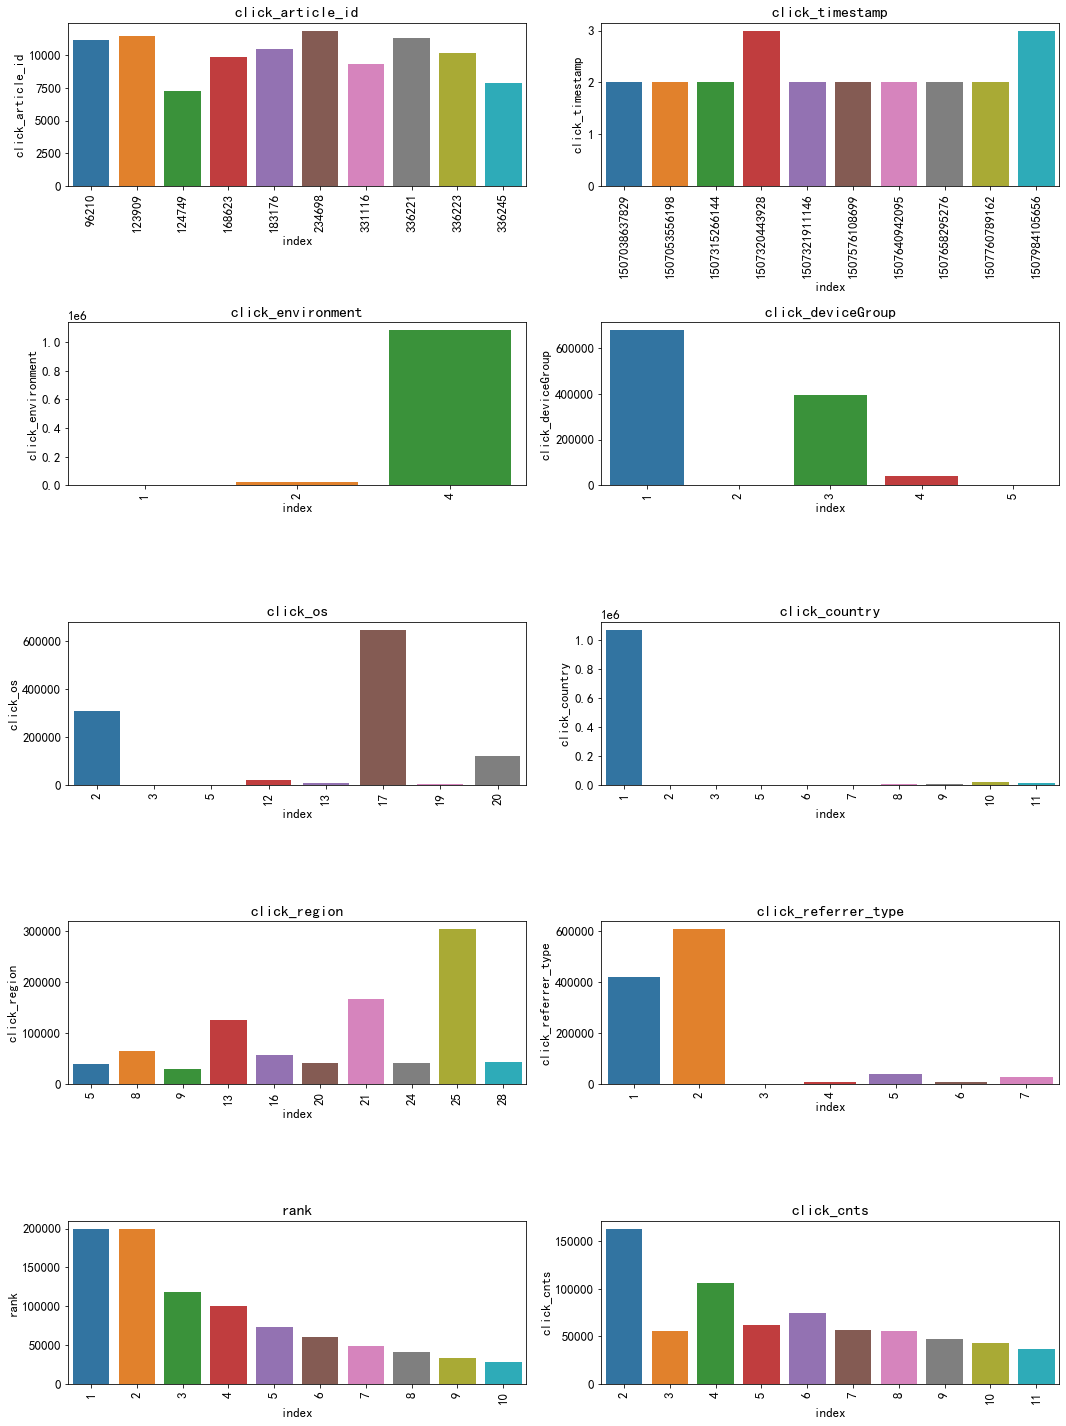

In [10]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

ps: click_cnts直方图表示的是每篇文章对应用户的点击次数累计图

In [11]:
trn_click['click_environment'].value_counts()

4    1084627
2      25894
1       2102
Name: click_environment, dtype: int64

从点击环境click_environment来看，仅有2102次（占0.19%）点击环境为1；仅有25894次（占2.3%）点击环境为2；剩余（占97.6%）点击环境为4。

In [12]:
trn_click['click_deviceGroup'].value_counts()

1    678187
3    395558
4     38731
5       141
2         6
Name: click_deviceGroup, dtype: int64

设备1占大部分（61%），设备3占36%

### 测试集用户点击日志

In [13]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [14]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


训练集的用户ID由0 ~ 199999，测试集A的用户ID由200000 ~ 249999。

In [15]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()

50000

In [16]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

### 新闻文章信息数据表

In [17]:
#新闻文章数据集浏览
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [18]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
        ... 
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

461


<AxesSubplot:>

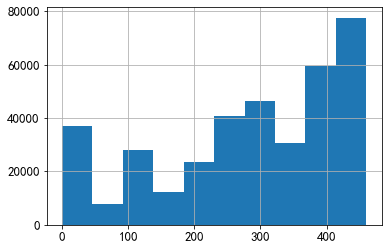

In [19]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

In [20]:
item_df.shape       # 364047篇文章

(364047, 4)

### 新闻文章embedding向量表示

In [21]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [22]:
item_emb_df.shape

(364047, 251)

### 用户重复点击

In [23]:
#####merge
user_click_merge = trn_click.append(tst_click)

In [24]:
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [25]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [26]:
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13], dtype=int64)

In [27]:
#用户点击新闻次数
user_click_count.loc[:,'count'].value_counts() 

1     1605541
2       11621
3         422
4          77
5          26
6          12
10          4
7           3
13          1
Name: count, dtype: int64

###### 分析可得：有1605541（约占99.2%）的用户未重复阅读过文章，仅有极少数用户重复点击过某篇文章。 这个也可以单独制作成特征

### 用户点击环境变化分析

In [28]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v['index'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

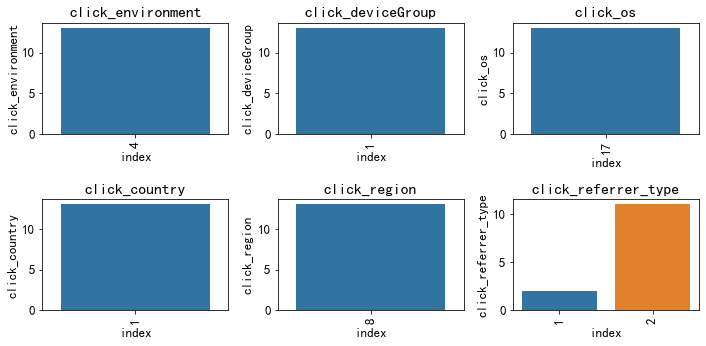

<Figure size 432x288 with 0 Axes>

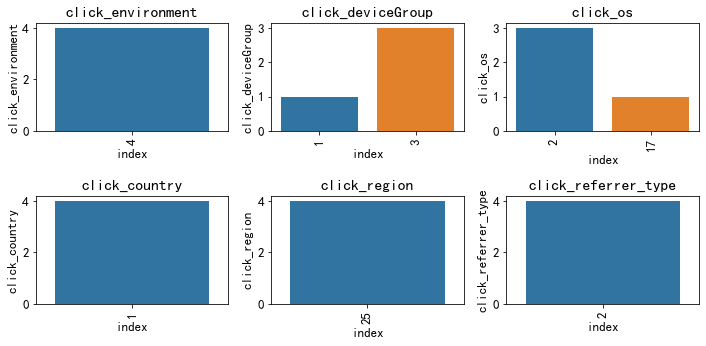

<Figure size 432x288 with 0 Axes>

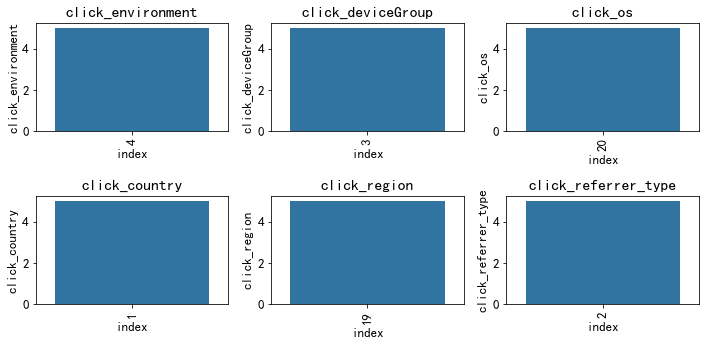

<Figure size 432x288 with 0 Axes>

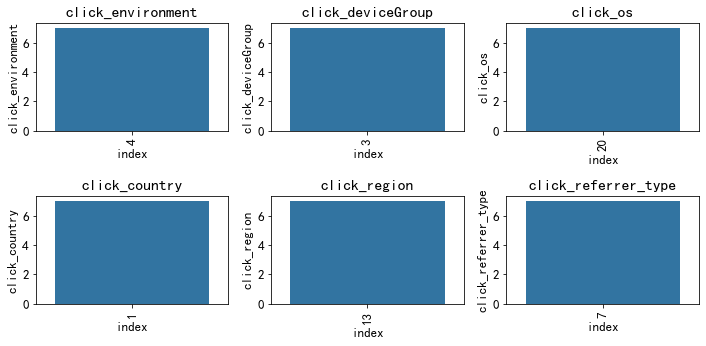

<Figure size 432x288 with 0 Axes>

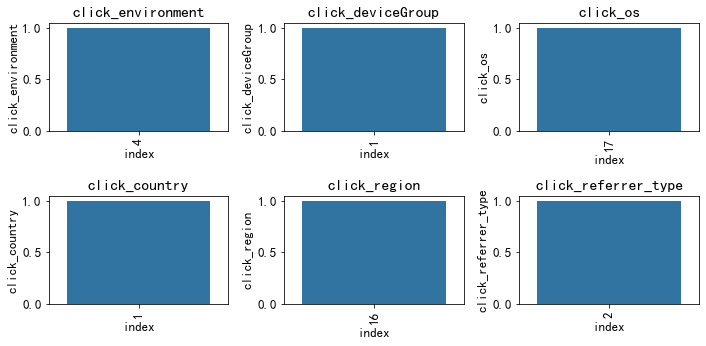

<Figure size 432x288 with 0 Axes>

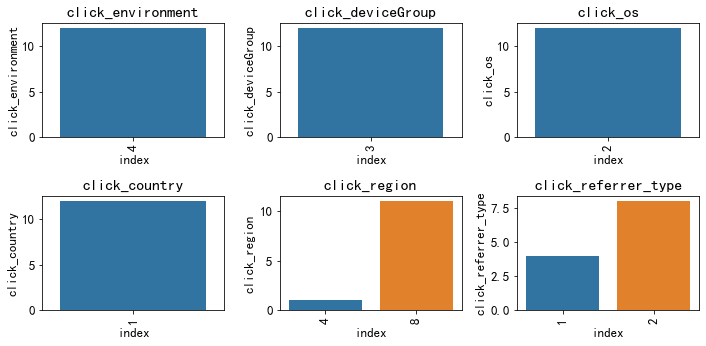

<Figure size 432x288 with 0 Axes>

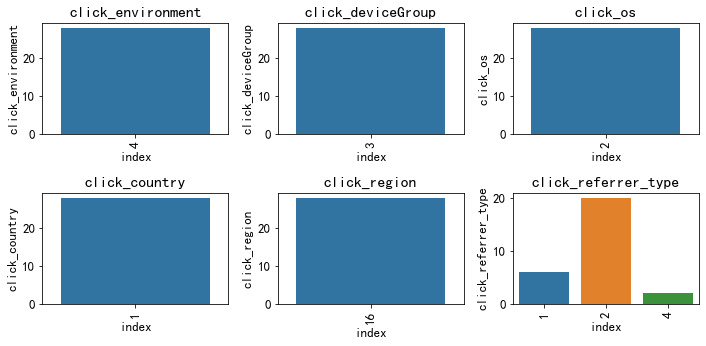

<Figure size 432x288 with 0 Axes>

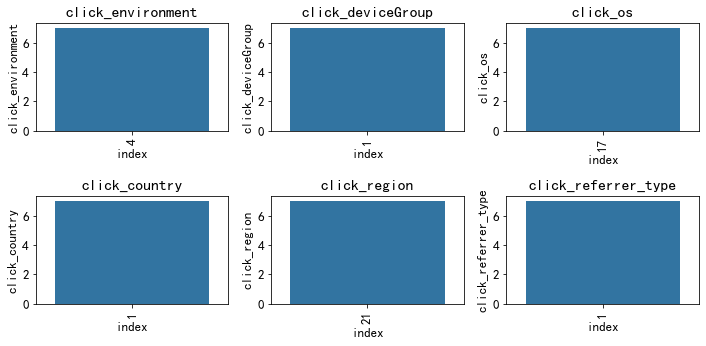

<Figure size 432x288 with 0 Axes>

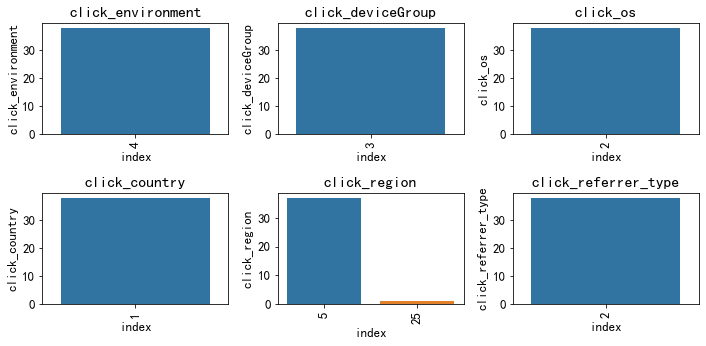

<Figure size 432x288 with 0 Axes>

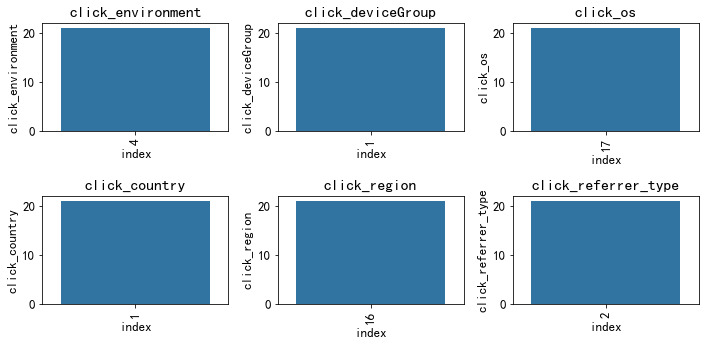

In [29]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

由于点击环境比较固定，我i们可以基于这些环境的统计特征来代表该用户本身的属性

### 用户点击新闻数量的分布

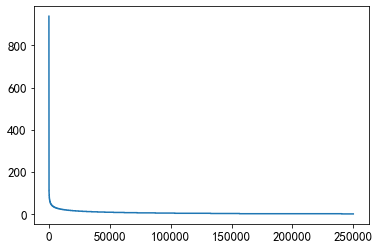

In [30]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

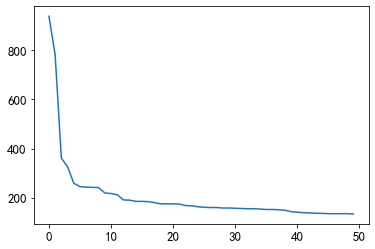

In [31]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

我们可以定义点击次数大于等于100次的用户为活跃用户

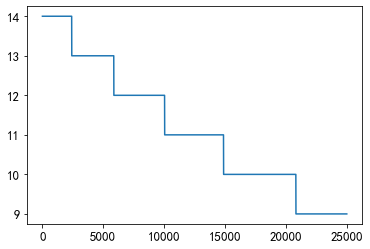

In [32]:
#点击次数排名在[25000:50000]之间
plt.plot(user_click_item_count[25000:50000])

可以看出点击次数小于等于两次的用户非常的多，这些用户可以认为是非活跃用户

### 新闻点击次数分析

In [33]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)

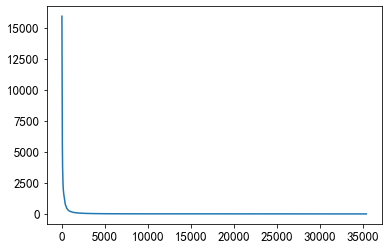

In [34]:
plt.plot(item_click_count)

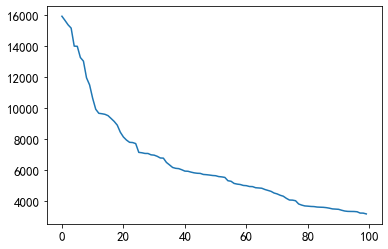

In [35]:
plt.plot(item_click_count[:100])

可以看出点击次数最多的前100篇新闻，点击次数大于1000次

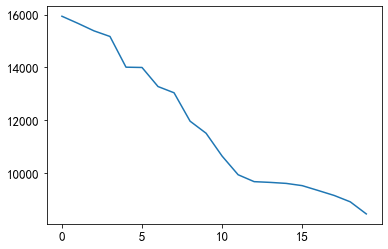

In [36]:
plt.plot(item_click_count[:20])

点击次数最多的前20篇新闻，点击次数大于2500。我们可以定义这些新闻为热门新闻

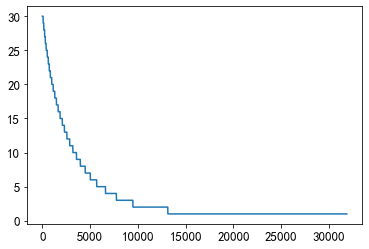

In [37]:
plt.plot(item_click_count[3500:])

可以把这些只被点击过一两次的新闻定义为是冷门新闻

### 新闻共现频次：两篇新闻连续出现的次数

In [38]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


平均共现次数3.18，最高为2202 这说明用户看的新闻的相关性是较强。

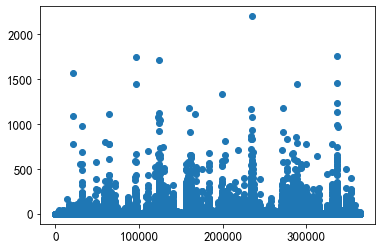

In [39]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

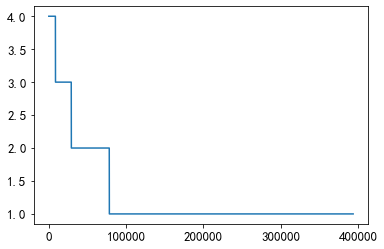

In [40]:
plt.plot(union_item['count'].values[40000:])

### 新闻文章信息

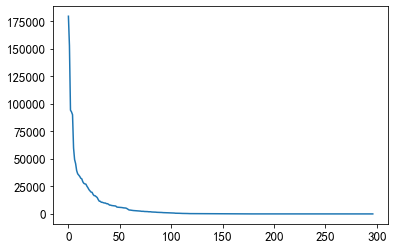

In [41]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

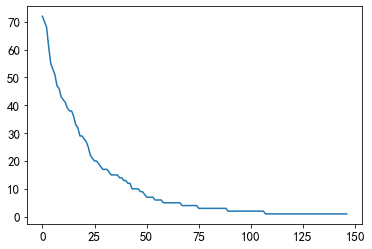

In [42]:
#出现次数比较少的新闻类型, 有些新闻类型，基本上就出现过几次
plt.plot(user_click_merge['category_id'].value_counts().values[150:])

In [43]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

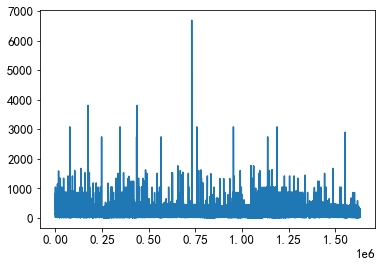

In [44]:
plt.plot(user_click_merge['words_count'].values)

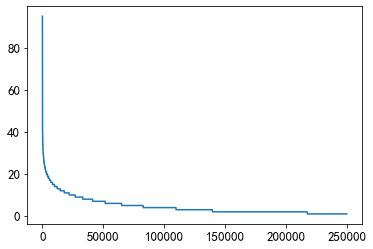

In [45]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

从上图中可以看出有一小部分用户阅读类型是极其广泛的，大部分人都处在20个新闻类型以下。

In [46]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


### 用户查看文章的长度的分布

通过统计不同用户点击新闻的平均字数，这个可以反映用户是对长文更感兴趣还是对短文更感兴趣。

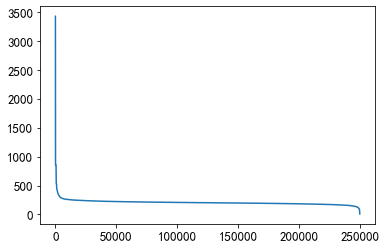

In [47]:
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True))

从上图中可以发现有一小部分人看的文章平均词数非常高，也有一小部分人看的平均文章次数非常低。其中大多数人偏好于阅读字数在200-400字之间的新闻。

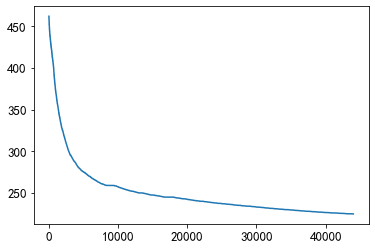

In [48]:
#挑出大多数人的区间仔细看看
plt.plot(sorted(user_click_merge.groupby('user_id')['words_count'].mean(), reverse=True)[1000:45000])

集中在250以下

In [49]:
#更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


## 用户点击新闻的时间分析

In [50]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

In [51]:
user_click_merge.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
18,249990,162300,0.000000,4,3,20,1,25,2,5,5,281,0.989186,193
2,249998,160974,0.000002,4,1,12,1,13,2,5,5,281,0.989092,259
30,249985,160974,0.000003,4,1,17,1,8,2,8,8,281,0.989092,259
50,249979,162300,0.000004,4,1,17,1,25,2,2,2,281,0.989186,193
25,249988,160974,0.000004,4,1,17,1,21,2,17,17,281,0.989092,259


In [52]:
def mean_diff_time_func(df, col):
    df = pd.DataFrame(df, columns={col})
    df['time_shift1'] = df[col].shift(1).fillna(0)
    df['diff_time'] = abs(df[col] - df['time_shift1'])
    return df['diff_time'].mean()

In [53]:
# 点击时间差的平均值
mean_diff_click_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'click_timestamp'))

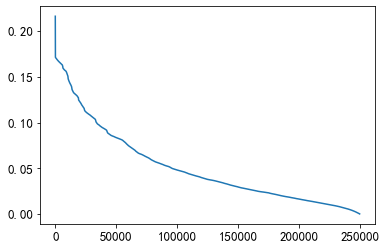

In [54]:
plt.plot(sorted(mean_diff_click_time.values, reverse=True))

In [55]:
# 前后点击文章的创建时间差的平均值
mean_diff_created_time = user_click_merge.groupby('user_id')['click_timestamp', 'created_at_ts'].apply(lambda x: mean_diff_time_func(x, 'created_at_ts'))

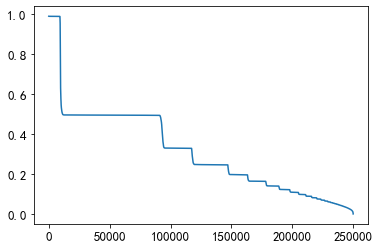

In [56]:
plt.plot(sorted(mean_diff_created_time.values, reverse=True))

从图中可以发现用户先后点击文章，文章的创建时间也是有差异的

In [57]:
# 安装gensim
!pip install gensim

In [58]:
from gensim.models import Word2Vec
import logging, pickle

# 需要注意这里模型只迭代了一次
def trian_item_word2vec(click_df, embed_size=16, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=10)
    
    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    
    return item_w2v_emb_dict

In [59]:
item_w2v_emb_dict = trian_item_word2vec(user_click_merge)

2020-12-28 10:55:12,763:INFO:collecting all words and their counts
2020-12-28 10:55:12,764:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-28 10:55:12,773:INFO:PROGRESS: at sentence #10000, processed 25727 words, keeping 3473 word types
2020-12-28 10:55:12,783:INFO:PROGRESS: at sentence #20000, processed 53883 words, keeping 5811 word types
2020-12-28 10:55:12,795:INFO:PROGRESS: at sentence #30000, processed 84881 words, keeping 7676 word types
2020-12-28 10:55:12,806:INFO:PROGRESS: at sentence #40000, processed 118390 words, keeping 9297 word types
2020-12-28 10:55:12,820:INFO:PROGRESS: at sentence #50000, processed 154179 words, keeping 10844 word types
2020-12-28 10:55:12,835:INFO:PROGRESS: at sentence #60000, processed 192350 words, keeping 12357 word types
2020-12-28 10:55:12,860:INFO:PROGRESS: at sentence #70000, processed 233685 words, keeping 13473 word types
2020-12-28 10:55:12,885:INFO:PROGRESS: at sentence #80000, processed 281335 words, keepin

2020-12-28 10:55:23,952:INFO:worker thread finished; awaiting finish of 1 more threads
2020-12-28 10:55:23,958:INFO:worker thread finished; awaiting finish of 0 more threads
2020-12-28 10:55:23,959:INFO:EPOCH - 2 : training on 1630633 raw words (1453149 effective words) took 2.1s, 685808 effective words/s
2020-12-28 10:55:24,987:INFO:EPOCH 3 - PROGRESS: at 63.48% examples, 658566 words/s, in_qsize 45, out_qsize 2
2020-12-28 10:55:25,850:INFO:worker thread finished; awaiting finish of 23 more threads
2020-12-28 10:55:25,859:INFO:worker thread finished; awaiting finish of 22 more threads
2020-12-28 10:55:25,863:INFO:worker thread finished; awaiting finish of 21 more threads
2020-12-28 10:55:25,867:INFO:worker thread finished; awaiting finish of 20 more threads
2020-12-28 10:55:25,881:INFO:worker thread finished; awaiting finish of 19 more threads
2020-12-28 10:55:25,887:INFO:worker thread finished; awaiting finish of 18 more threads
2020-12-28 10:55:25,891:INFO:worker thread finished; aw

2020-12-28 10:55:32,186:INFO:worker thread finished; awaiting finish of 17 more threads
2020-12-28 10:55:32,188:INFO:worker thread finished; awaiting finish of 16 more threads
2020-12-28 10:55:32,193:INFO:worker thread finished; awaiting finish of 15 more threads
2020-12-28 10:55:32,203:INFO:worker thread finished; awaiting finish of 14 more threads
2020-12-28 10:55:32,225:INFO:worker thread finished; awaiting finish of 13 more threads
2020-12-28 10:55:32,229:INFO:worker thread finished; awaiting finish of 12 more threads
2020-12-28 10:55:32,241:INFO:worker thread finished; awaiting finish of 11 more threads
2020-12-28 10:55:32,243:INFO:worker thread finished; awaiting finish of 10 more threads
2020-12-28 10:55:32,248:INFO:worker thread finished; awaiting finish of 9 more threads
2020-12-28 10:55:32,250:INFO:worker thread finished; awaiting finish of 8 more threads
2020-12-28 10:55:32,253:INFO:worker thread finished; awaiting finish of 7 more threads
2020-12-28 10:55:32,266:INFO:worker

2020-12-28 10:55:38,207:INFO:worker thread finished; awaiting finish of 5 more threads
2020-12-28 10:55:38,217:INFO:worker thread finished; awaiting finish of 4 more threads
2020-12-28 10:55:38,220:INFO:worker thread finished; awaiting finish of 3 more threads
2020-12-28 10:55:38,222:INFO:worker thread finished; awaiting finish of 2 more threads
2020-12-28 10:55:38,227:INFO:worker thread finished; awaiting finish of 1 more threads
2020-12-28 10:55:38,229:INFO:worker thread finished; awaiting finish of 0 more threads
2020-12-28 10:55:38,229:INFO:EPOCH - 9 : training on 1630633 raw words (1453395 effective words) took 1.9s, 765520 effective words/s
2020-12-28 10:55:39,260:INFO:EPOCH 10 - PROGRESS: at 65.98% examples, 707231 words/s, in_qsize 46, out_qsize 1
2020-12-28 10:55:39,951:INFO:worker thread finished; awaiting finish of 23 more threads
2020-12-28 10:55:39,961:INFO:worker thread finished; awaiting finish of 22 more threads
2020-12-28 10:55:39,985:INFO:worker thread finished; await

In [60]:
# 随机选择5个用户，查看这些用户前后查看文章的相似性
sub_user_ids = np.random.choice(user_click_merge.user_id.unique(), size=15, replace=False)
sub_user_info = user_click_merge[user_click_merge['user_id'].isin(sub_user_ids)]

sub_user_info.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
2809,248884,203293,0.000201,4,3,2,1,5,4,1,1,327,0.989173,156
21394,241388,96812,0.002195,4,1,17,1,13,2,1,1,209,0.989201,195
49004,231436,59758,0.004168,4,1,17,1,5,2,5,5,123,0.988958,213
49005,231436,363173,0.004177,4,1,17,1,5,2,4,5,455,0.989196,168
83489,218886,64329,0.006928,2,3,20,1,21,2,1,1,134,0.989259,199


In [61]:
#将训练得到的词向量进行可视化
def get_item_sim_list(df):
    sim_list = []
    item_list = df['click_article_id'].values
    for i in range(0, len(item_list)-1):
        emb1 = item_w2v_emb_dict[str(item_list[i])] # 需要注意的是word2vec训练时候使用的是str类型的数据
        emb2 = item_w2v_emb_dict[str(item_list[i+1])]
        sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
    sim_list.append(0)
    return sim_list

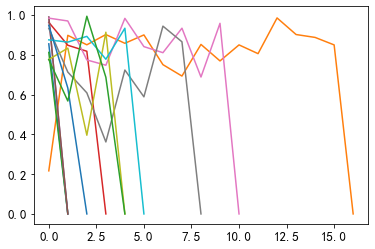

In [62]:
for _, user_df in sub_user_info.groupby('user_id'):
    item_sim_list = get_item_sim_list(user_df)
    plt.plot(item_sim_list)

由于迭代次数不多还需多次训练

# 第二步 多路召回

前期准备

安装faiss、deepctr、deepmatch

In [63]:
pip install deepctr

Note: you may need to restart the kernel to use updated packages.


In [64]:
pip install deepmatch

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd  
import numpy as np
from tqdm import tqdm  
from collections import defaultdict  
import os, math, warnings, math, pickle
from tqdm import tqdm
import faiss
import collections
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss
warnings.filterwarnings('ignore')

2020-12-28 10:58:14,332:INFO:Loading faiss.


Please check the latest version manually on https://pypi.org/project/deepctr/#history
Please check the latest version manually on https://pypi.org/project/deepmatch/#history


In [66]:
data_path = r'F:\新闻推荐\data/'
save_path = r'F:\新闻推荐\temp_results/'
# metric_recall做召回评估的一个标志, 如果不进行评估就是直接使用全量数据进行召回
metric_recall = False

## 读取数据

In [67]:
# debug模式： 从训练集中划出一部分数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        训练集中采样一部分数据调试
        data_path: 原数据的存储路径
        sample_nums: 采样数目（这里由于机器的内存限制，可以采样用户做）
    """
    all_click = pd.read_csv(data_path + 'train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False) 
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

# 读取点击数据，这里分成线上和线下，如果是为了获取线上提交结果应该讲测试集中的点击数据合并到总的数据中
# 如果是为了线下验证模型的有效性或者特征的有效性，可以只使用训练集
def get_all_click_df(data_path=r'F:\新闻推荐\data/', offline=True):
    if offline:
        all_click = pd.read_csv(data_path + 'train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + 'train_click_log.csv')
        tst_click = pd.read_csv(data_path + 'testA_click_log.csv')

        all_click = trn_click.append(tst_click)
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

In [68]:
# 读取文章的基本属性
def get_item_info_df(data_path):
    item_info_df = pd.read_csv(data_path + 'articles.csv')
    
    # 为了方便与训练集中的click_article_id拼接，需要把article_id修改成click_article_id
    item_info_df = item_info_df.rename(columns={'article_id': 'click_article_id'})
    
    return item_info_df

In [69]:
# 读取文章的Embedding数据
def get_item_emb_dict(data_path):
    item_emb_df = pd.read_csv(data_path + 'articles_emb.csv')
    
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols])
    # 进行归一化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)

    item_emb_dict = dict(zip(item_emb_df['article_id'], item_emb_np))
    pickle.dump(item_emb_dict, open(save_path + 'item_content_emb.pkl', 'wb'))
    
    return item_emb_dict

In [70]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))

In [71]:
# 采样数据
# all_click_df = get_all_click_sample(data_path)

# 全量训练集
all_click_df = get_all_click_df(offline=False)

# 对时间戳进行归一化,用于在关联规则的时候计算权重
all_click_df['click_timestamp'] = all_click_df[['click_timestamp']].apply(max_min_scaler)

In [72]:
item_info_df = get_item_info_df(data_path)

In [73]:
item_emb_dict = get_item_emb_dict(data_path)

### 获取用户-文章-时间函数

In [74]:
# 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
def get_user_item_time(click_df):
    
    click_df = click_df.sort_values('click_timestamp')
    
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    user_item_time_df = click_df.groupby('user_id')['click_article_id', 'click_timestamp'].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict

In [75]:
# 根据时间获取商品被点击的用户序列  {item1: [(user1, time1), (user2, time2)...]...}
# 时间是用户点击当前商品的时间
def get_item_user_time_dict(click_df):
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))
    
    click_df = click_df.sort_values('click_timestamp')
    item_user_time_df = click_df.groupby('click_article_id')['user_id', 'click_timestamp'].apply(lambda x: make_user_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'user_time_list'})
    
    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict

### 获取历史和最后一次点击
用于特征工程和制作标签转成监督学习测试集

In [76]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    
    all_click = all_click.sort_values(by=['user_id', 'click_timestamp'])
    click_last_df = all_click.groupby('user_id').tail(1)

    # 如果用户只有一个点击，hist为空了，会导致训练的时候这个用户不可见，此时默认泄露一下
    def hist_func(user_df):
        if len(user_df) == 1:
            return user_df
        else:
            return user_df[:-1]

    click_hist_df = all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)

    return click_hist_df, click_last_df

### 获取文章属性特征

In [77]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段直接使用
def get_item_info_dict(item_info_df):
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_info_df['created_at_ts'] = item_info_df[['created_at_ts']].apply(max_min_scaler)
    
    item_type_dict = dict(zip(item_info_df['click_article_id'], item_info_df['category_id']))
    item_words_dict = dict(zip(item_info_df['click_article_id'], item_info_df['words_count']))
    item_created_time_dict = dict(zip(item_info_df['click_article_id'], item_info_df['created_at_ts']))
    
    return item_type_dict, item_words_dict, item_created_time_dict

In [78]:
def get_user_hist_item_info_dict(all_click):
    
    # 获取user_id对应的用户历史点击文章类型的集合字典
    user_hist_item_typs = all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict = dict(zip(user_hist_item_typs['user_id'], user_hist_item_typs['category_id']))
    
    # 获取user_id对应的用户点击文章的集合
    user_hist_item_ids_dict = all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict = dict(zip(user_hist_item_ids_dict['user_id'], user_hist_item_ids_dict['click_article_id']))
    
    # 获取user_id对应的用户历史点击的文章的平均字数字典
    user_hist_item_words = all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict = dict(zip(user_hist_item_words['user_id'], user_hist_item_words['words_count']))
    
    # 获取user_id对应的用户最后一次点击的文章的创建时间
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    
    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'], \
                                                user_last_item_created_time['created_at_ts']))
    
    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict

### 获取点击次数最多的topk个文章

In [79]:
# 获取近期点击最多的文章
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click

## 定义多路召回字典

In [80]:
# 获取文章的属性信息，保存成字典的形式方便查询
item_type_dict, item_words_dict, item_created_time_dict = get_item_info_dict(item_info_df)

In [81]:
# 定义一个多路召回的字典，将各路召回的结果都保存在这个字典当中
user_multi_recall_dict =  {'itemcf_sim_itemcf_recall': {},
                           'embedding_sim_item_recall': {},
                           'youtubednn_recall': {},
                           'youtubednn_usercf_recall': {}, 
                           'cold_start_recall': {}}

## 计算相似性矩阵

In [82]:
def itemcf_sim(df, item_created_time_dict):
    """
        文章与文章之间的相似性矩阵计算
        :param df: 数据表
        :item_created_time_dict:  文章创建时间的字典
        return : 文章与文章的相似性矩阵
        
        思路: 基于物品的协同过滤(详细请参考上一期推荐系统基础的组队学习) + 关联规则
    """
    
    user_item_time_dict = get_user_item_time(df)
    
    # 计算物品相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for loc1, (i, i_click_time) in enumerate(item_time_list):
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for loc2, (j, j_click_time) in enumerate(item_time_list):
                if(i == j):
                    continue
                    
                # 考虑文章的正向顺序点击和反向顺序点击    
                loc_alpha = 1.0 if loc2 > loc1 else 0.7
                # 位置信息权重，其中的参数可以调节
                loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                # 点击时间权重，其中的参数可以调节
                click_time_weight = np.exp(0.7 ** np.abs(i_click_time - j_click_time))
                # 两篇文章创建时间的权重，其中的参数可以调节
                created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                i2i_sim[i].setdefault(j, 0)
                # 考虑多种因素的权重计算最终的文章之间的相似度
                i2i_sim[i][j] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)
                
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))
    
    return i2i_sim_

In [83]:
i2i_sim = itemcf_sim(all_click_df, item_created_time_dict)

100%|██████████| 250000/250000 [05:24<00:00, 771.40it/s] 


In [84]:
def get_user_activate_degree_dict(all_click_df):
    all_click_df_ = all_click_df.groupby('user_id')['click_article_id'].count().reset_index()
    
    # 用户活跃度归一化
    mm = MinMaxScaler()
    all_click_df_['click_article_id'] = mm.fit_transform(all_click_df_[['click_article_id']])
    user_activate_degree_dict = dict(zip(all_click_df_['user_id'], all_click_df_['click_article_id']))
    
    return user_activate_degree_dict

In [85]:
def usercf_sim(all_click_df, user_activate_degree_dict):
    """
        用户相似性矩阵计算
        :param all_click_df: 数据表
        :param user_activate_degree_dict: 用户活跃度的字典
        return 用户相似性矩阵
        
        思路: 基于用户的协同过滤(详细请参考上一期推荐系统基础的组队学习) + 关联规则
    """
    item_user_time_dict = get_item_user_time_dict(all_click_df)
    
    u2u_sim = {}
    user_cnt = defaultdict(int)
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        for u, click_time in user_time_list:
            user_cnt[u] += 1
            u2u_sim.setdefault(u, {})
            for v, click_time in user_time_list:
                u2u_sim[u].setdefault(v, 0)
                if u == v:
                    continue
                # 用户平均活跃度作为活跃度的权重，这里的式子也可以改善
                activate_weight = 100 * 0.5 * (user_activate_degree_dict[u] + user_activate_degree_dict[v])   
                u2u_sim[u][v] += activate_weight / math.log(len(user_time_list) + 1)
    
    u2u_sim_ = u2u_sim.copy()
    for u, related_users in u2u_sim.items():
        for v, wij in related_users.items():
            u2u_sim_[u][v] = wij / math.sqrt(user_cnt[u] * user_cnt[v])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(u2u_sim_, open(save_path + 'usercf_u2u_sim.pkl', 'wb'))

    return u2u_sim_

In [87]:
user_activate_degree_dict = get_user_activate_degree_dict(all_click_df)

In [88]:
# 向量检索相似度计算
# topk指的是每个item, faiss搜索后返回最相似的topk个item
def embdding_sim(click_df, item_emb_df, save_path, topk):
    """
        基于内容的文章embedding相似性矩阵计算
        :param click_df: 数据表
        :param item_emb_df: 文章的embedding
        :param save_path: 保存路径
        :patam topk: 找最相似的topk篇
        return 文章相似性矩阵
        
        思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 只不过由于文章数量太多，这里用了faiss进行加速
    """
    
    # 文章索引与文章id的字典映射
    item_idx_2_rawid_dict = dict(zip(item_emb_df.index, item_emb_df['article_id']))
    
    item_emb_cols = [x for x in item_emb_df.columns if 'emb' in x]
    item_emb_np = np.ascontiguousarray(item_emb_df[item_emb_cols].values, dtype=np.float32)
    # 向量进行单位化
    item_emb_np = item_emb_np / np.linalg.norm(item_emb_np, axis=1, keepdims=True)
    
    # 建立faiss索引
    item_index = faiss.IndexFlatIP(item_emb_np.shape[1])
    item_index.add(item_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = item_index.search(item_emb_np, topk) # 返回的是列表
    
    # 将向量检索的结果保存成原始id的对应关系
    item_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_emb_np)), sim, idx)):
        target_raw_id = item_idx_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_idx_2_rawid_dict[rele_idx]
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(item_sim_dict, open(save_path + 'emb_i2i_sim.pkl', 'wb'))   
    
    return item_sim_dict

In [89]:
item_emb_df = pd.read_csv(data_path + '/articles_emb.csv')
emb_i2i_sim = embdding_sim(all_click_df, item_emb_df, save_path, topk=10) # topk可以自行设置

364047it [00:13, 27157.89it/s]


In [90]:
# 获取双塔召回时的训练验证数据
# negsample指的是通过滑窗构建样本的时候，负样本的数量
def gen_data_set(data, negsample=0):
    data.sort_values("click_timestamp", inplace=True)
    item_ids = data['click_article_id'].unique()

    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['click_article_id'].tolist()
        
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))   # 用户没看过的文章里面选择负样本
            neg_list = np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True)  # 对于每个正样本，选择n个负样本
            
        # 长度只有一个的时候，需要把这条数据也放到训练集中，不然的话最终学到的embedding就会有缺失
        if len(pos_list) == 1:
            train_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            test_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            
        # 滑窗构造正负样本
        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            
            if i != len(pos_list) - 1:
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1])))  # 正样本 [user_id, his_item, pos_item, label, len(his_item)]
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0,len(hist[::-1]))) # 负样本 [user_id, his_item, neg_item, label, len(his_item)]
            else:
                # 将最长的那一个序列长度作为测试数据
                test_set.append((reviewerID, hist[::-1], pos_list[i],1,len(hist[::-1])))
                
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    return train_set, test_set

# 将输入的数据进行padding，使得序列特征的长度都一致
def gen_model_input(train_set,user_profile,seq_max_len):

    train_uid = np.array([line[0] for line in train_set])
    train_seq = [line[1] for line in train_set]
    train_iid = np.array([line[2] for line in train_set])
    train_label = np.array([line[3] for line in train_set])
    train_hist_len = np.array([line[4] for line in train_set])

    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    train_model_input = {"user_id": train_uid, "click_article_id": train_iid, "hist_article_id": train_seq_pad,
                         "hist_len": train_hist_len}

    return train_model_input, train_label

In [91]:
def youtubednn_u2i_dict(data, topk=20):    
    sparse_features = ["click_article_id", "user_id"]
    SEQ_LEN = 30 # 用户点击序列的长度，短的填充，长的截断
    
    user_profile_ = data[["user_id"]].drop_duplicates('user_id')
    item_profile_ = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    # 类别编码
    features = ["click_article_id", "user_id"]
    feature_max_idx = {}
    
    for feature in features:
        lbe = LabelEncoder()
        data[feature] = lbe.fit_transform(data[feature])
        feature_max_idx[feature] = data[feature].max() + 1
    
    # 提取user和item的画像，这里具体选择哪些特征还需要进一步的分析和考虑
    user_profile = data[["user_id"]].drop_duplicates('user_id')
    item_profile = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    user_index_2_rawid = dict(zip(user_profile['user_id'], user_profile_['user_id']))
    item_index_2_rawid = dict(zip(item_profile['click_article_id'], item_profile_['click_article_id']))
    
    # 划分训练和测试集
    # 由于深度学习需要的数据量通常都是非常大的，所以为了保证召回的效果，往往会通过滑窗的形式扩充训练样本
    train_set, test_set = gen_data_set(data, 0)
    # 整理输入数据，具体的操作可以看上面的函数
    train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
    test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)
    
    # 确定Embedding的维度
    embedding_dim = 16
    
    # 将数据整理成模型可以直接输入的形式
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_article_id', feature_max_idx['click_article_id'], embedding_dim,
                                                        embedding_name="click_article_id"), SEQ_LEN, 'mean', 'hist_len'),]
    item_feature_columns = [SparseFeat('click_article_id', feature_max_idx['click_article_id'], embedding_dim)]
    
    # 模型的定义 
    # num_sampled: 负采样时的样本数量
    model = YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, user_dnn_hidden_units=(64, embedding_dim))
    # 模型编译
    model.compile(optimizer="adam", loss=sampledsoftmaxloss)  
    
    # 模型训练，这里可以定义验证集的比例，如果设置为0的话就是全量数据直接进行训练
    history = model.fit(train_model_input, train_label, batch_size=256, epochs=1, verbose=1, validation_split=0.0)
    
    # 训练完模型之后,提取训练的Embedding，包括user端和item端
    test_user_model_input = test_model_input
    all_item_model_input = {"click_article_id": item_profile['click_article_id'].values}

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
    
    # 保存当前的item_embedding 和 user_embedding 排序的时候可能能够用到，但是需要注意保存的时候需要和原始的id对应
    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)
    
    # embedding保存之前归一化一下
    user_embs = user_embs / np.linalg.norm(user_embs, axis=1, keepdims=True)
    item_embs = item_embs / np.linalg.norm(item_embs, axis=1, keepdims=True)
    
    # 将Embedding转换成字典的形式方便查询
    raw_user_id_emb_dict = {user_index_2_rawid[k]: \
                                v for k, v in zip(user_profile['user_id'], user_embs)}
    raw_item_id_emb_dict = {item_index_2_rawid[k]: \
                                v for k, v in zip(item_profile['click_article_id'], item_embs)}
    # 将Embedding保存到本地
    pickle.dump(raw_user_id_emb_dict, open(save_path + 'user_youtube_emb.pkl', 'wb'))
    pickle.dump(raw_item_id_emb_dict, open(save_path + 'item_youtube_emb.pkl', 'wb'))
    
    # faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item
    index = faiss.IndexFlatIP(embedding_dim)
    # 上面已经进行了归一化，这里可以不进行归一化了
#     faiss.normalize_L2(user_embs)
#     faiss.normalize_L2(item_embs)
    index.add(item_embs) # 将item向量构建索引
    sim, idx = index.search(np.ascontiguousarray(user_embs), topk) # 通过user去查询最相似的topk个item
    
    user_recall_items_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(test_user_model_input['user_id'], sim, idx)):
        target_raw_id = user_index_2_rawid[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index_2_rawid[rele_idx]
            user_recall_items_dict[target_raw_id][rele_raw_id] = user_recall_items_dict.get(target_raw_id, {})\
                                                                    .get(rele_raw_id, 0) + sim_value
            
    user_recall_items_dict = {k: sorted(v.items(), key=lambda x: x[1], reverse=True) for k, v in user_recall_items_dict.items()}
    # 将召回的结果进行排序
    
    # 保存召回的结果
    # 这里是直接通过向量的方式得到了召回结果，相比于上面的召回方法，上面的只是得到了i2i及u2u的相似性矩阵，还需要进行协同过滤召回才能得到召回结果
    # 可以直接对这个召回结果进行评估，为了方便可以统一写一个评估函数对所有的召回结果进行评估
    pickle.dump(user_recall_items_dict, open(save_path + 'youtube_u2i_dict.pkl', 'wb'))
    return user_recall_items_dict

In [92]:
# 由于这里需要做召回评估，所以讲训练集中的最后一次点击都提取了出来
if not metric_recall:
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(all_click_df, topk=20)
else:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
    user_multi_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(trn_hist_click_df, topk=20)
    # 召回效果评估
    metrics_recall(user_multi_recall_dict.get['youtubednn_recall'], trn_last_click_df, topk=20)

In [93]:
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc,(i,click_time) in enumerate(user_hist_items):
        for j,wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue
            
            # 文章创建时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
            # 相似文章和历史点击文章序列中历史文章所在的位置权重
            loc_weight = (0.9 ** (len(user_hist_items) - loc))
            
            content_weight = 1.0
            if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                content_weight += emb_i2i_sim[i][j]
            if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                content_weight += emb_i2i_sim[j][i]
                
            item_rank.setdefault(j, 0)
            item_rank[j] += created_time_weight * loc_weight * content_weight * wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items(): # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

In [95]:
# 这里是为了召回评估，所以提取最后一次点击
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb'))

sim_item_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)

for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, 
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['embedding_sim_item_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['embedding_sim_item_recall'], open(save_path + 'embedding_sim_item_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['embedding_sim_item_recall'], trn_last_click_df, topk=recall_item_num)

100%|██████████| 250000/250000 [01:34<00:00, 2656.90it/s]


In [96]:
# 基于用户的召回 u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num, 
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param u2u_sim: 字典，文章相似性矩阵
        :param sim_user_topk: 整数， 选择与当前用户最相似的前k个用户
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param item_created_time_dict: 文章创建时间列表
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 历史交互
    user_item_time_list = user_item_time_dict[user_id]    #  [(item1, time1), (item2, time2)..]
    user_hist_items = set([i for i, t in user_item_time_list])   # 存在一个用户与某篇文章的多次交互， 这里得去重
    
    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)
            
            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0
            
            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # 内容相似性权重
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]
                
                # 创建时间差权重
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                
            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv
        
    # 热度补全
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank.items(): # 填充的item应该不在原来的列表中
                continue
            items_rank[item] = - i - 100 # 随便给个复数就行
            if len(items_rank) == recall_item_num:
                break
        
    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]    
    
    return items_rank

In [97]:
# 使用Embedding的方式获取u2u的相似性矩阵
# topk指的是每个user, faiss搜索后返回最相似的topk个user
def u2u_embdding_sim(click_df, user_emb_dict, save_path, topk):
    
    user_list = []
    user_emb_list = []
    for user_id, user_emb in user_emb_dict.items():
        user_list.append(user_id)
        user_emb_list.append(user_emb)
        
    user_index_2_rawid_dict = {k: v for k, v in zip(range(len(user_list)), user_list)}    
    
    user_emb_np = np.array(user_emb_list, dtype=np.float32)
    
    # 建立faiss索引
    user_index = faiss.IndexFlatIP(user_emb_np.shape[1])
    user_index.add(user_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = user_index.search(user_emb_np, topk) # 返回的是列表
   
    # 将向量检索的结果保存成原始id的对应关系
    user_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(user_emb_np)), sim, idx)):
        target_raw_id = user_index_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = user_index_2_rawid_dict[rele_idx]
            user_sim_dict[target_raw_id][rele_raw_id] = user_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(user_sim_dict, open(save_path + 'youtube_u2u_sim.pkl', 'wb'))   
    return user_sim_dict

In [98]:
# 读取YoutubeDNN过程中产生的user embedding, 然后使用faiss计算用户之间的相似度
# 这里需要注意，这里得到的user embedding其实并不是很好，因为YoutubeDNN中使用的是用户点击序列来训练的user embedding,
# 如果序列普遍都比较短的话，其实效果并不是很好
user_emb_dict = pickle.load(open(save_path + 'user_youtube_emb.pkl', 'rb'))
u2u_sim = u2u_embdding_sim(all_click_df, user_emb_dict, save_path, topk=10)

In [99]:
# 使用召回评估函数验证当前召回方式的效果
if metric_recall:
    trn_hist_click_df, trn_last_click_df = get_hist_and_last_click(all_click_df)
else:
    trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
u2u_sim = pickle.load(open(save_path + 'youtube_u2u_sim.pkl', 'rb'))

sim_user_topk = 20
recall_item_num = 10

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, item_topk_click, item_created_time_dict, emb_i2i_sim)
    
user_multi_recall_dict['youtubednn_usercf_recall'] = user_recall_items_dict
pickle.dump(user_multi_recall_dict['youtubednn_usercf_recall'], open(save_path + 'youtubednn_usercf_recall.pkl', 'wb'))

if metric_recall:
    # 召回效果评估
    metrics_recall(user_multi_recall_dict['youtubednn_usercf_recall'], trn_last_click_df, topk=recall_item_num)

## 冷启动

In [100]:
# 先进行itemcf召回，这里不需要做召回评估，这里只是一种策略
trn_hist_click_df = all_click_df

user_recall_items_dict = collections.defaultdict(dict)
user_item_time_dict = get_user_item_time(trn_hist_click_df)
i2i_sim = pickle.load(open(save_path + 'emb_i2i_sim.pkl','rb'))

sim_item_topk = 150
recall_item_num = 100 # 稍微召回多一点文章，便于后续的规则筛选

item_topk_click = get_item_topk_click(trn_hist_click_df, k=50)
for user in tqdm(trn_hist_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, sim_item_topk, 
                                                        recall_item_num, item_topk_click,item_created_time_dict, emb_i2i_sim)
pickle.dump(user_recall_items_dict, open(save_path + 'cold_start_items_raw_dict.pkl', 'wb'))

100%|██████████| 250000/250000 [01:49<00:00, 2283.48it/s]


In [101]:
# 基于规则进行文章过滤
# 保留文章主题与用户历史浏览主题相似的文章
# 保留文章字数与用户历史浏览文章字数相差不大的文章
# 保留最后一次点击当天的文章
# 按照相似度返回最终的结果

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                     user_last_item_created_time_dict, item_type_dict, item_words_dict, 
                     item_created_time_dict, click_article_ids_set, recall_item_num):
    """
        冷启动的情况下召回一些文章
        :param user_recall_items_dict: 基于内容embedding相似性召回来的很多文章， 字典， {user1: [(item1, item2), ..], }
        :param user_hist_item_typs_dict: 字典， 用户点击的文章的主题映射
        :param user_hist_item_words_dict: 字典， 用户点击的历史文章的字数映射
        :param user_last_item_created_time_idct: 字典，用户点击的历史文章创建时间映射
        :param item_tpye_idct: 字典，文章主题映射
        :param item_words_dict: 字典，文章字数映射
        :param item_created_time_dict: 字典， 文章创建时间映射
        :param click_article_ids_set: 集合，用户点击过得文章, 也就是日志里面出现过的文章
        :param recall_item_num: 召回文章的数量， 这个指的是没有出现在日志里面的文章数量
    """
    
    cold_start_user_items_dict = {}
    for user, item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user, [])
        for item, score in item_list:
            # 获取历史文章信息
            hist_item_type_set = user_hist_item_typs_dict[user]
            hist_mean_words = user_hist_item_words_dict[user]
            hist_last_item_created_time = user_last_item_created_time_dict[user]
            hist_last_item_created_time = datetime.fromtimestamp(hist_last_item_created_time)
            
            # 获取当前召回文章的信息
            curr_item_type = item_type_dict[item]
            curr_item_words = item_words_dict[item]
            curr_item_created_time = item_created_time_dict[item]
            curr_item_created_time = datetime.fromtimestamp(curr_item_created_time)

            # 首先，文章不能出现在用户的历史点击中， 然后根据文章主题，文章单词数，文章创建时间进行筛选
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words - hist_mean_words) > 200 or \
                abs((curr_item_created_time - hist_last_item_created_time).days) > 90: 
                continue
                
            cold_start_user_items_dict[user].append((item, score))      # {user1: [(item1, score1), (item2, score2)..]...}
    
    # 需要控制一下冷启动召回的数量
    cold_start_user_items_dict = {k: sorted(v, key=lambda x:x[1], reverse=True)[:recall_item_num] \
                                  for k, v in cold_start_user_items_dict.items()}
    
    pickle.dump(cold_start_user_items_dict, open(save_path + 'cold_start_user_items_dict.pkl', 'wb'))
    
    return cold_start_user_items_dict

In [102]:
all_click_df_ = all_click_df.copy()
all_click_df_ = all_click_df_.merge(item_info_df, how='left', on='click_article_id')
user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict = get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_click_df)
# 需要注意的是
# 这里使用了很多规则来筛选冷启动的文章，所以前面再召回的阶段就应该尽可能的多召回一些文章，否则很容易被删掉
cold_start_user_items_dict = cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)

user_multi_recall_dict['cold_start_recall'] = cold_start_user_items_dict

100%|██████████| 250000/250000 [00:55<00:00, 4524.56it/s]


## 多路召回合并

In [103]:
def combine_recall_results(user_multi_recall_dict, weight_dict=None, topk=25):
    final_recall_items_dict = {}
    
    # 对每一种召回结果按照用户进行归一化，方便后面多种召回结果，相同用户的物品之间权重相加
    def norm_user_recall_items_sim(sorted_item_list):
        # 如果冷启动中没有文章或者只有一篇文章，直接返回，出现这种情况的原因可能是冷启动召回的文章数量太少了，
        # 基于规则筛选之后就没有文章了, 这里还可以做一些其他的策略性的筛选
        if len(sorted_item_list) < 2:
            return sorted_item_list
        
        min_sim = sorted_item_list[-1][1]
        max_sim = sorted_item_list[0][1]
        
        norm_sorted_item_list = []
        for item, score in sorted_item_list:
            if max_sim > 0:
                norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
            else:
                norm_score = 0.0
            norm_sorted_item_list.append((item, norm_score))
            
        return norm_sorted_item_list
    
    print('多路召回合并...')
    for method, user_recall_items in tqdm(user_multi_recall_dict.items()):
        print(method + '...')
        # 在计算最终召回结果的时候，也可以为每一种召回结果设置一个权重
        if weight_dict == None:
            recall_method_weight = 1
        else:
            recall_method_weight = weight_dict[method]
        
        for user_id, sorted_item_list in user_recall_items.items(): # 进行归一化
            user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)
        
        for user_id, sorted_item_list in user_recall_items.items():
            # print('user_id')
            final_recall_items_dict.setdefault(user_id, {})
            for item, score in sorted_item_list:
                final_recall_items_dict[user_id].setdefault(item, 0)
                final_recall_items_dict[user_id][item] += recall_method_weight * score  
    
    final_recall_items_dict_rank = {}
    # 多路召回时也可以控制最终的召回数量
    for user, recall_item_dict in final_recall_items_dict.items():
        final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

    # 将多路召回后的最终结果字典保存到本地
    pickle.dump(final_recall_items_dict_rank, open(os.path.join(save_path, 'final_recall_items_dict.pkl'),'wb'))

    return final_recall_items_dict_rank

In [104]:
# 这里直接对多路召回的权重给了一个相同的值，其实可以根据前面召回的情况来调整参数的值
weight_dict = {'itemcf_sim_itemcf_recall': 1.0,
               'embedding_sim_item_recall': 1.0,
               'youtubednn_recall': 1.0,
               'youtubednn_usercf_recall': 1.0, 
               'cold_start_recall': 1.0}

In [105]:
# 最终合并之后每个用户召回150个商品进行排序
final_recall_items_dict_rank = combine_recall_results(user_multi_recall_dict, weight_dict, topk=150)

  0%|          | 0/5 [00:00<?, ?it/s]

多路召回合并...
itemcf_sim_itemcf_recall...
embedding_sim_item_recall...


 40%|████      | 2/5 [00:06<00:09,  3.06s/it]

youtubednn_recall...
youtubednn_usercf_recall...
cold_start_recall...


100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


# 制作特征和标签， 转化为监督学习问题

In [106]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [107]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import gc, os
import logging
import time
import lightgbm as lgb
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [108]:
# df节省内存函数
# 减少内存
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [109]:
data_path = r'F:\新闻推荐\data/'
save_path = r'F:\新闻推荐\temp_results/'

## 训练和验证集的划分

In [110]:
# all_click_df指的是训练集
# sample_user_nums 采样作为验证集的用户数量
def trn_val_split(all_click_df, sample_user_nums):
    all_click = all_click_df
    all_user_ids = all_click.user_id.unique()
    
    # replace=True表示可以重复抽样，反之不可以
    sample_user_ids = np.random.choice(all_user_ids, size=sample_user_nums, replace=False) 
    
    click_val = all_click[all_click['user_id'].isin(sample_user_ids)]
    click_trn = all_click[~all_click['user_id'].isin(sample_user_ids)]
    
    # 将验证集中的最后一次点击给抽取出来作为答案
    click_val = click_val.sort_values(['user_id', 'click_timestamp'])
    val_ans = click_val.groupby('user_id').tail(1)
    
    click_val = click_val.groupby('user_id').apply(lambda x: x[:-1]).reset_index(drop=True)
    
    # 去除val_ans中某些用户只有一个点击数据的情况，如果该用户只有一个点击数据，又被分到ans中，
    # 那么训练集中就没有这个用户的点击数据，出现用户冷启动问题，给自己模型验证带来麻烦
    val_ans = val_ans[val_ans.user_id.isin(click_val.user_id.unique())] # 保证答案中出现的用户再验证集中还有
    click_val = click_val[click_val.user_id.isin(val_ans.user_id.unique())]
    
    return click_trn, click_val, val_ans

In [111]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(all_click):
    all_click = all_click.sort_values(by=['user_id', 'click_timestamp'])
    click_last_df = all_click.groupby('user_id').tail(1)

    # 如果用户只有一个点击，hist为空了，会导致训练的时候这个用户不可见，此时默认泄露一下
    def hist_func(user_df):
        if len(user_df) == 1:
            return user_df
        else:
            return user_df[:-1]

    click_hist_df = all_click.groupby('user_id').apply(hist_func).reset_index(drop=True)

    return click_hist_df, click_last_df

In [112]:
def get_trn_val_tst_data(data_path, offline=True):
    if offline:
        click_trn_data = pd.read_csv(data_path+'train_click_log.csv')  # 训练集用户点击日志
        click_trn_data = reduce_mem(click_trn_data)
        click_trn, click_val, val_ans = trn_val_split(click_trn_data, sample_user_nums)
    else:
        click_trn = pd.read_csv(data_path+'train_click_log.csv')
        click_trn = reduce_mem(click_trn)
        click_val = None
        val_ans = None
    
    click_tst = pd.read_csv(data_path+'testA_click_log.csv')
    
    return click_trn, click_val, click_tst, val_ans

In [113]:
# 返回多路召回列表或者单路召回
def get_recall_list(save_path, single_recall_model=None, multi_recall=False):
    if multi_recall:
        return pickle.load(open(save_path + 'final_recall_items_dict.pkl', 'rb'))

    if single_recall_model == 'i2i_itemcf':
        return pickle.load(open(save_path + 'itemcf_recall_dict.pkl', 'rb'))
    elif single_recall_model == 'i2i_emb_itemcf':
        return pickle.load(open(save_path + 'itemcf_emb_dict.pkl', 'rb'))
    elif single_recall_model == 'user_cf':
        return pickle.load(open(save_path + 'youtubednn_usercf_dict.pkl', 'rb'))
    elif single_recall_model == 'youtubednn':
        return pickle.load(open(save_path + 'youtube_u2i_dict.pkl', 'rb'))

In [114]:
def trian_item_word2vec(click_df, embed_size=64, save_name='item_w2v_emb.pkl', split_char=' '):
    click_df = click_df.sort_values('click_timestamp')
    # 只有转换成字符串才可以进行训练
    click_df['click_article_id'] = click_df['click_article_id'].astype(str)
    # 转换成句子的形式
    docs = click_df.groupby(['user_id'])['click_article_id'].apply(lambda x: list(x)).reset_index()
    docs = docs['click_article_id'].values.tolist()

    # 为了方便查看训练的进度，这里设定一个log信息
    logging.basicConfig(format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

    # 这里的参数对训练得到的向量影响也很大,默认负采样为5
    w2v = Word2Vec(docs, size=16, sg=1, window=5, seed=2020, workers=24, min_count=1, iter=1)
    
    # 保存成字典的形式
    item_w2v_emb_dict = {k: w2v[k] for k in click_df['click_article_id']}
    pickle.dump(item_w2v_emb_dict, open(save_path + 'item_w2v_emb.pkl', 'wb'))
    
    return item_w2v_emb_dict

In [139]:
# 可以通过字典查询对应的item的Embedding
def get_embedding(save_path, all_click_df):
    if os.path.exists(save_path + 'item_content_emb.pkl'):
        a = pickle.load(open(save_path + 'item_content_emb.pkl', 'rb'))
    else:
        print('item_content_emb.pkl 文件不存在...')
        
    # w2v Embedding是需要提前训练好的
    if os.path.exists(save_path + 'item_w2v_emb.pkl'):
        b = pickle.load(open(save_path + 'item_w2v_emb.pkl', 'rb'))
    else:
        b = trian_item_word2vec(all_click_df)
    
    return a,b,

## 读取文章信息

In [116]:
def get_article_info_df():
    article_info_df = pd.read_csv(data_path + 'articles.csv')
    article_info_df = reduce_mem(article_info_df)
    
    return article_info_df

In [117]:
# 这里offline的online的区别就是验证集是否为空
click_trn, click_val, click_tst, val_ans = get_trn_val_tst_data(data_path, offline=False)

-- Mem. usage decreased to 23.34 Mb (69.4% reduction),time spend:0.00 min


In [118]:
click_trn_hist, click_trn_last = get_hist_and_last_click(click_trn)

if click_val is not None:
    click_val_hist, click_val_last = click_val, val_ans
else:
    click_val_hist, click_val_last = None, None
    
click_tst_hist = click_tst

In [119]:
# 将召回列表转换成df的形式
def recall_dict_2_df(recall_list_dict):
    df_row_list = [] # [user, item, score]
    for user, recall_list in tqdm(recall_list_dict.items()):
        for item, score in recall_list:
            df_row_list.append([user, item, score])
    
    col_names = ['user_id', 'sim_item', 'score']
    recall_list_df = pd.DataFrame(df_row_list, columns=col_names)
    
    return recall_list_df

In [120]:
# 负采样函数，这里可以控制负采样时的比例, 这里给了一个默认的值
def neg_sample_recall_data(recall_items_df, sample_rate=0.001):
    pos_data = recall_items_df[recall_items_df['label'] == 1]
    neg_data = recall_items_df[recall_items_df['label'] == 0]
    
    print('pos_data_num:', len(pos_data), 'neg_data_num:', len(neg_data), 'pos/neg:', len(pos_data)/len(neg_data))
    
    # 分组采样函数
    def neg_sample_func(group_df):
        neg_num = len(group_df)
        sample_num = max(int(neg_num * sample_rate), 1) # 保证最少有一个
        sample_num = min(sample_num, 5) # 保证最多不超过5个，这里可以根据实际情况进行选择
        return group_df.sample(n=sample_num, replace=True)
    
    # 对用户进行负采样，保证所有用户都在采样后的数据中
    neg_data_user_sample = neg_data.groupby('user_id', group_keys=False).apply(neg_sample_func)
    # 对文章进行负采样，保证所有文章都在采样后的数据中
    neg_data_item_sample = neg_data.groupby('sim_item', group_keys=False).apply(neg_sample_func)
    
    # 将上述两种情况下的采样数据合并
    neg_data_new = neg_data_user_sample.append(neg_data_item_sample)
    # 由于上述两个操作是分开的，可能将两个相同的数据给重复选择了，所以需要对合并后的数据进行去重
    neg_data_new = neg_data_new.sort_values(['user_id', 'score']).drop_duplicates(['user_id', 'sim_item'], keep='last')
    
    # 将正样本数据合并
    data_new = pd.concat([pos_data, neg_data_new], ignore_index=True)
    
    return data_new

In [121]:
# 召回数据打标签
def get_rank_label_df(recall_list_df, label_df, is_test=False):
    # 测试集是没有标签了，为了后面代码同一一些，这里直接给一个负数替代
    if is_test:
        recall_list_df['label'] = -1
        return recall_list_df
    
    label_df = label_df.rename(columns={'click_article_id': 'sim_item'})
    recall_list_df_ = recall_list_df.merge(label_df[['user_id', 'sim_item', 'click_timestamp']], \
                                               how='left', on=['user_id', 'sim_item'])
    recall_list_df_['label'] = recall_list_df_['click_timestamp'].apply(lambda x: 0.0 if np.isnan(x) else 1.0)
    del recall_list_df_['click_timestamp']
    
    return recall_list_df_

In [122]:
def get_user_recall_item_label_df(click_trn_hist, click_val_hist, click_tst_hist,click_trn_last, click_val_last, recall_list_df):
    # 获取训练数据的召回列表
    trn_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_trn_hist['user_id'].unique())]
    # 训练数据打标签
    trn_user_item_label_df = get_rank_label_df(trn_user_items_df, click_trn_last, is_test=False)
    # 训练数据负采样
    trn_user_item_label_df = neg_sample_recall_data(trn_user_item_label_df)
    
    if click_val is not None:
        val_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_val_hist['user_id'].unique())]
        val_user_item_label_df = get_rank_label_df(val_user_items_df, click_val_last, is_test=False)
        val_user_item_label_df = neg_sample_recall_data(val_user_item_label_df)
    else:
        val_user_item_label_df = None
        
    # 测试数据不需要进行负采样，直接对所有的召回商品进行打-1标签
    tst_user_items_df = recall_list_df[recall_list_df['user_id'].isin(click_tst_hist['user_id'].unique())]
    tst_user_item_label_df = get_rank_label_df(tst_user_items_df, None, is_test=True)
    
    return trn_user_item_label_df, val_user_item_label_df, tst_user_item_label_df

In [124]:
# 读取召回列表
recall_list_dict = get_recall_list(save_path,single_recall_model=None, multi_recall=True) # 这里选择了多路召回结果
# 将召回数据转换成df
recall_list_df = recall_dict_2_df(recall_list_dict)

100%|██████████| 250000/250000 [00:12<00:00, 20794.25it/s] 


In [125]:
# 给训练验证数据打标签，并负采样
trn_user_item_label_df, val_user_item_label_df, tst_user_item_label_df = get_user_recall_item_label_df(click_trn_hist, 
                                                                                                       click_val_hist, 
                                                                                                       click_tst_hist,
                                                                                                       click_trn_last, 
                                                                                                       click_val_last, 
                                                                                                       recall_list_df)

pos_data_num: 1 neg_data_num: 2028890 pos/neg: 4.928803434390233e-07


## 将召回数据转换成字典

In [126]:
# 将最终的召回的df数据转换成字典的形式做排序特征
def make_tuple_func(group_df):
    row_data = []
    for name, row_df in group_df.iterrows():
        row_data.append((row_df['sim_item'], row_df['score'], row_df['label']))
    
    return row_data

In [127]:
trn_user_item_label_tuples = trn_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
trn_user_item_label_tuples_dict = dict(zip(trn_user_item_label_tuples['user_id'], trn_user_item_label_tuples[0]))

if val_user_item_label_df is not None:
    val_user_item_label_tuples = val_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
    val_user_item_label_tuples_dict = dict(zip(val_user_item_label_tuples['user_id'], val_user_item_label_tuples[0]))
else:
    val_user_item_label_tuples_dict = None
    
tst_user_item_label_tuples = tst_user_item_label_df.groupby('user_id').apply(make_tuple_func).reset_index()
tst_user_item_label_tuples_dict = dict(zip(tst_user_item_label_tuples['user_id'], tst_user_item_label_tuples[0]))

# 特征工程

In [128]:
# 下面基于data做历史相关的特征
def create_feature(users_id, recall_list, click_hist_df,  articles_info, articles_emb, user_emb=None, N=1):
    """
    基于用户的历史行为做相关特征
    :param users_id: 用户id
    :param recall_list: 对于每个用户召回的候选文章列表
    :param click_hist_df: 用户的历史点击信息
    :param articles_info: 文章信息
    :param articles_emb: 文章的embedding向量, 这个可以用item_content_emb, item_w2v_emb, item_youtube_emb
    :param user_emb: 用户的embedding向量， 这个是user_youtube_emb, 如果没有也可以不用， 但要注意如果要用的话， articles_emb就要用item_youtube_emb的形式， 这样维度才一样
    :param N: 最近的N次点击  由于testA日志里面很多用户只存在一次历史点击， 所以为了不产生空值，默认是1
    """
    
    # 建立一个二维列表保存结果， 后面要转成DataFrame
    all_user_feas = []
    i = 0
    for user_id in tqdm(users_id):
        # 该用户的最后N次点击
        hist_user_items = click_hist_df[click_hist_df['user_id']==user_id]['click_article_id'][-N:]
        
        # 遍历该用户的召回列表
        for rank, (article_id, score, label) in enumerate(recall_list[user_id]):
            # 该文章建立时间, 字数
            a_create_time = articles_info[articles_info['article_id']==article_id]['created_at_ts'].values[0]
            a_words_count = articles_info[articles_info['article_id']==article_id]['words_count'].values[0]
            single_user_fea = [user_id, article_id]
            # 计算与最后点击的商品的相似度的和， 最大值和最小值， 均值
            sim_fea = []
            time_fea = []
            word_fea = []
            # 遍历用户的最后N次点击文章
            for hist_item in hist_user_items:
                b_create_time = articles_info[articles_info['article_id']==hist_item]['created_at_ts'].values[0]
                b_words_count = articles_info[articles_info['article_id']==hist_item]['words_count'].values[0]
                
                sim_fea.append(np.dot(articles_emb[hist_item], articles_emb[article_id]))
                time_fea.append(abs(a_create_time-b_create_time))
                word_fea.append(abs(a_words_count-b_words_count))
                
            single_user_fea.extend(sim_fea)      # 相似性特征
            single_user_fea.extend(time_fea)    # 时间差特征
            single_user_fea.extend(word_fea)    # 字数差特征
            single_user_fea.extend([max(sim_fea), min(sim_fea), sum(sim_fea), sum(sim_fea) / len(sim_fea)])  # 相似性的统计特征
            
            if user_emb:  # 如果用户向量有的话， 这里计算该召回文章与用户的相似性特征 
                single_user_fea.append(np.dot(user_emb[user_id], articles_emb[article_id]))
                
            single_user_fea.extend([score, rank, label])    
            # 加入到总的表中
            all_user_feas.append(single_user_fea)
    
    # 定义列名
    id_cols = ['user_id', 'click_article_id']
    sim_cols = ['sim' + str(i) for i in range(N)]
    time_cols = ['time_diff' + str(i) for i in range(N)]
    word_cols = ['word_diff' + str(i) for i in range(N)]
    sat_cols = ['sim_max', 'sim_min', 'sim_sum', 'sim_mean']
    user_item_sim_cols = ['user_item_sim'] if user_emb else []
    user_score_rank_label = ['score', 'rank', 'label']
    cols = id_cols + sim_cols + time_cols + word_cols + sat_cols + user_item_sim_cols + user_score_rank_label
            
    # 转成DataFrame
    df = pd.DataFrame( all_user_feas, columns=cols)
    
    return df

In [140]:
article_info_df = get_article_info_df()
all_click = click_trn.append(click_tst)
item_content_emb_dict, item_w2v_emb_dict = get_embedding(save_path, all_click)

-- Mem. usage decreased to  5.56 Mb (50.0% reduction),time spend:0.00 min


In [194]:
# 获取训练验证及测试数据中召回列文章相关特征
trn_user_item_feats_df = create_feature(trn_user_item_label_tuples_dict.keys(), trn_user_item_label_tuples_dict, \
                                            click_trn_hist, article_info_df, item_content_emb_dict)

if val_user_item_label_tuples_dict is not None:
    val_user_item_feats_df = create_feature(val_user_item_label_tuples_dict.keys(), val_user_item_label_tuples_dict, \
                                                click_val_hist, article_info_df, item_content_emb_dict)
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = create_feature(tst_user_item_label_tuples_dict.keys(), tst_user_item_label_tuples_dict, \
                                            click_tst_hist, article_info_df, item_content_emb_dict)

100%|██████████| 50000/50000 [46:50<00:00, 17.79it/s] 


In [196]:
#保存一份省的每次都要重新跑，每次跑的时间都比较长
trn_user_item_feats_df.to_csv(save_path + 'trn_user_item_feats_df.csv', index=False)

if val_user_item_feats_df is not None:
    val_user_item_feats_df.to_csv(save_path + 'val_user_item_feats_df.csv', index=False)

tst_user_item_feats_df.to_csv(save_path + 'tst_user_item_feats_df.csv', index=False)    

In [197]:
click_tst.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,249999,160974,1506959142820,4,1,17,1,13,2
1,249999,160417,1506959172820,4,1,17,1,13,2
2,249998,160974,1506959056066,4,1,12,1,13,2
3,249998,202557,1506959086066,4,1,12,1,13,2
4,249997,183665,1506959088613,4,1,17,1,15,5


In [198]:
# 读取文章特征
articles =  pd.read_csv(data_path+'articles.csv')
articles = reduce_mem(articles)

# 日志数据，就是前面的所有数据
if click_val is not None:
    all_data = click_trn.append(click_val)
all_data = click_trn.append(click_tst)
all_data = reduce_mem(all_data)

# 拼上文章信息
all_data = all_data.merge(articles, left_on='click_article_id', right_on='article_id')

-- Mem. usage decreased to  5.56 Mb (50.0% reduction),time spend:0.00 min
-- Mem. usage decreased to 46.65 Mb (62.5% reduction),time spend:0.00 min


In [199]:
all_data.shape

(1630633, 13)

In [200]:
def active_level(all_data, cols):
    """
    制作区分用户活跃度的特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    data = all_data[cols]
    data.sort_values(['user_id', 'click_timestamp'], inplace=True)
    user_act = pd.DataFrame(data.groupby('user_id', as_index=False)[['click_article_id', 'click_timestamp']].\
                            agg({'click_article_id':np.size, 'click_timestamp': {list}}).values, columns=['user_id', 'click_size', 'click_timestamp'])
    
    # 计算时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 1
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    user_act['time_diff_mean'] = user_act['click_timestamp'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    user_act['click_size'] = 1 / user_act['click_size']
    
    # 两者归一化
    user_act['click_size'] = (user_act['click_size'] - user_act['click_size'].min()) / (user_act['click_size'].max() - user_act['click_size'].min())
    user_act['time_diff_mean'] = (user_act['time_diff_mean'] - user_act['time_diff_mean'].min()) / (user_act['time_diff_mean'].max() - user_act['time_diff_mean'].min())     
    user_act['active_level'] = user_act['click_size'] + user_act['time_diff_mean']
    
    user_act['user_id'] = user_act['user_id'].astype('int')
    del user_act['click_timestamp']
    
    return user_act

In [201]:
user_act_fea = active_level(all_data, ['user_id', 'click_article_id', 'click_timestamp'])

In [202]:
user_act_fea.head()

,user_id,click_size,time_diff_mean,active_level
0,0,0.499466,0.000048,0.499515
1,1,0.499466,0.000048,0.499515
2,2,0.499466,0.000048,0.499515
3,3,0.499466,0.000048,0.499515
4,4,0.499466,0.000048,0.499515


In [203]:
def hot_level(all_data, cols):
    """
    制作衡量文章热度的特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    data = all_data[cols]
    data.sort_values(['click_article_id', 'click_timestamp'], inplace=True)
    article_hot = pd.DataFrame(data.groupby('click_article_id', as_index=False)[['user_id', 'click_timestamp']].\
                               agg({'user_id':np.size, 'click_timestamp': {list}}).values, columns=['click_article_id', 'user_num', 'click_timestamp'])
    
    # 计算被点击时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 1
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    article_hot['time_diff_mean'] = article_hot['click_timestamp'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    article_hot['user_num'] = 1 / article_hot['user_num']
    
    # 两者归一化
    article_hot['user_num'] = (article_hot['user_num'] - article_hot['user_num'].min()) / (article_hot['user_num'].max() - article_hot['user_num'].min())
    article_hot['time_diff_mean'] = (article_hot['time_diff_mean'] - article_hot['time_diff_mean'].min()) / (article_hot['time_diff_mean'].max() - article_hot['time_diff_mean'].min())     
    article_hot['hot_level'] = article_hot['user_num'] + article_hot['time_diff_mean']
    
    article_hot['click_article_id'] = article_hot['click_article_id'].astype('int')
    
    del article_hot['click_timestamp']
    
    return article_hot

In [204]:
article_hot_fea = hot_level(all_data, ['user_id', 'click_article_id', 'click_timestamp'])    

In [205]:
article_hot_fea.head()

,click_article_id,user_num,time_diff_mean,hot_level
0,3,1,0.0,1
1,69,1,0.0,1
2,84,1,0.0,1
3,94,1,0.0,1
4,125,1,0.0,1


In [206]:
#用户的设备习惯
def device_fea(all_data, cols):
    """
    制作用户的设备特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_device_info = all_data[cols]
    
    # 用众数来表示每个用户的设备信息
    user_device_info = user_device_info.groupby('user_id').agg(lambda x: x.value_counts().index[0]).reset_index()
    
    return user_device_info

In [207]:
# 设备特征(这里时间会比较长)
device_cols = ['user_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
user_device_info = device_fea(all_data, device_cols)

In [208]:
user_device_info.head()

,user_id,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,4,1,17,1,25,2
1,1,4,1,17,1,25,6
2,2,4,3,20,1,25,2
3,3,4,3,2,1,25,2
4,4,4,1,12,1,16,1


In [209]:
#用户的时间习惯
def user_time_hob_fea(all_data, cols):
    """
    制作用户的时间习惯特征
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_time_hob_info = all_data[cols]
    
    # 先把时间戳进行归一化
    mm = MinMaxScaler()
    user_time_hob_info['click_timestamp'] = mm.fit_transform(user_time_hob_info[['click_timestamp']])
    user_time_hob_info['created_at_ts'] = mm.fit_transform(user_time_hob_info[['created_at_ts']])

    user_time_hob_info = user_time_hob_info.groupby('user_id').agg('mean').reset_index()
    
    user_time_hob_info.rename(columns={'click_timestamp': 'user_time_hob1', 'created_at_ts': 'user_time_hob2'}, inplace=True)
    return user_time_hob_info

In [210]:
user_time_hob_cols = ['user_id', 'click_timestamp', 'created_at_ts']
user_time_hob_info = user_time_hob_fea(all_data, user_time_hob_cols)

In [211]:
def user_cat_hob_fea(all_data, cols):
    """
    用户的主题爱好
    :param all_data: 数据集
    :param cols: 用到的特征列
    """
    user_category_hob_info = all_data[cols]
    user_category_hob_info = user_category_hob_info.groupby('user_id').agg({list}).reset_index()
    
    user_cat_hob_info = pd.DataFrame()
    user_cat_hob_info['user_id'] = user_category_hob_info['user_id']
    user_cat_hob_info['cate_list'] = user_category_hob_info['category_id']
    
    return user_cat_hob_info

In [212]:
user_category_hob_cols = ['user_id', 'category_id']
user_cat_hob_info = user_cat_hob_fea(all_data, user_category_hob_cols)

In [213]:
user_wcou_info = all_data.groupby('user_id')['words_count'].agg('mean').reset_index()
user_wcou_info.rename(columns={'words_count': 'words_hbo'}, inplace=True)

In [214]:
# 所有表进行合并
user_info = pd.merge(user_act_fea, user_device_info, on='user_id')
user_info = user_info.merge(user_time_hob_info, on='user_id')
user_info = user_info.merge(user_cat_hob_info, on='user_id')
user_info = user_info.merge(user_wcou_info, on='user_id')

In [215]:
# 这样用户特征以后就可以直接读取了
user_info.to_csv(save_path + 'user_info.csv', index=False)   

### 用户特征直接读入

In [216]:
# 把用户信息直接读入进来
user_info = pd.read_csv(save_path + 'user_info.csv')

In [217]:
if os.path.exists(save_path + 'trn_user_item_feats_df.csv'):
    trn_user_item_feats_df = pd.read_csv(save_path + 'trn_user_item_feats_df.csv')
    
if os.path.exists(save_path + 'tst_user_item_feats_df.csv'):
    tst_user_item_feats_df = pd.read_csv(save_path + 'tst_user_item_feats_df.csv')

if os.path.exists(save_path + 'val_user_item_feats_df.csv'):
    val_user_item_feats_df = pd.read_csv(save_path + 'val_user_item_feats_df.csv')
else:
    val_user_item_feats_df = None

In [218]:
# 拼上用户特征
# 下面是线下验证的
trn_user_item_feats_df = trn_user_item_feats_df.merge(user_info, on='user_id', how='left')

if val_user_item_feats_df is not None:
    val_user_item_feats_df = val_user_item_feats_df.merge(user_info, on='user_id', how='left')
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = tst_user_item_feats_df.merge(user_info, on='user_id',how='left')

In [219]:
trn_user_item_feats_df.columns

Index(['user_id', 'click_article_id', 'sim0', 'time_diff0', 'word_diff0',
       'sim_max', 'sim_min', 'sim_sum', 'sim_mean', 'score', 'rank', 'label',
       'click_size', 'time_diff_mean', 'active_level', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type', 'user_time_hob1', 'user_time_hob2', 'cate_list',
       'words_hbo'],
      dtype='object')

## 文章特征读入

In [220]:
articles =  pd.read_csv(data_path+'articles.csv')
articles = reduce_mem(articles)

-- Mem. usage decreased to  5.56 Mb (50.0% reduction),time spend:0.00 min


In [221]:
# 拼上文章特征
trn_user_item_feats_df = trn_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')

if val_user_item_feats_df is not None:
    val_user_item_feats_df = val_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')
else:
    val_user_item_feats_df = None

tst_user_item_feats_df = tst_user_item_feats_df.merge(articles, left_on='click_article_id', right_on='article_id')

In [224]:
trn_user_item_feats_df['is_cat_hab'] = trn_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)
if val_user_item_feats_df is not None:
    val_user_item_feats_df['is_cat_hab'] = val_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)
else:
    val_user_item_feats_df = None
tst_user_item_feats_df['is_cat_hab'] = tst_user_item_feats_df.apply(lambda x: 1 if x.category_id in set(x.cate_list) else 0, axis=1)

In [225]:
# 线下验证
del trn_user_item_feats_df['cate_list']

if val_user_item_feats_df is not None:
    del val_user_item_feats_df['cate_list']
else:
    val_user_item_feats_df = None
    
del tst_user_item_feats_df['cate_list']

del trn_user_item_feats_df['article_id']

if val_user_item_feats_df is not None:
    del val_user_item_feats_df['article_id']
else:
    val_user_item_feats_df = None
    
del tst_user_item_feats_df['article_id']

In [226]:
# 训练验证特征并保存
trn_user_item_feats_df.to_csv(save_path + 'trn_user_item_feats_df.csv', index=False)
if val_user_item_feats_df is not None:
    val_user_item_feats_df.to_csv(save_path + 'val_user_item_feats_df.csv', index=False)
tst_user_item_feats_df.to_csv(save_path + 'tst_user_item_feats_df.csv', index=False)

# 排序模型
1. LGB的排序模型
2. LGB的分类模型
3. 深度学习的分类模型DIN
得到了最终的排序模型输出的结果之后使用两种比较经典的模型集成的方法：
1. 输出结果加权融合
2. Staking（将模型的输出结果再使用一个简单模型进行预测）

In [227]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import gc, os
import time
from datetime import datetime
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [228]:
offline = False

In [229]:
# 重新读取数据的时候，发现click_article_id是一个浮点数，所以将其转换成int类型
trn_user_item_feats_df = pd.read_csv(save_path + 'trn_user_item_feats_df.csv')
trn_user_item_feats_df['click_article_id'] = trn_user_item_feats_df['click_article_id'].astype(int)

if offline:
    val_user_item_feats_df = pd.read_csv(save_path + 'val_user_item_feats_df.csv')
    val_user_item_feats_df['click_article_id'] = val_user_item_feats_df['click_article_id'].astype(int)
else:
    val_user_item_feats_df = None
    
tst_user_item_feats_df = pd.read_csv(save_path + 'tst_user_item_feats_df.csv')
tst_user_item_feats_df['click_article_id'] = tst_user_item_feats_df['click_article_id'].astype(int)

# 做特征的时候为了方便，给测试集也打上了一个无效的标签，这里直接删掉就行
del tst_user_item_feats_df['label']

In [230]:
def submit(recall_df, topk=5, model_name=None):
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk
    
    del recall_df['pred_score']
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})
    
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'
    submit.to_csv(save_name, index=False, header=True)

In [231]:
# 排序结果归一化
def norm_sim(sim_df, weight=0.0):
    # print(sim_df.head())
    min_sim = sim_df.min()
    max_sim = sim_df.max()
    if max_sim == min_sim:
        sim_df = sim_df.apply(lambda sim: 1.0)
    else:
        sim_df = sim_df.apply(lambda sim: 1.0 * (sim - min_sim) / (max_sim - min_sim))

    sim_df = sim_df.apply(lambda sim: sim + weight)  # plus one
    return sim_df

LGB 排序模型

In [232]:
# 防止中间出错之后重新读取数据
trn_user_item_feats_df_rank_model = trn_user_item_feats_df.copy()

if offline:
    val_user_item_feats_df_rank_model = val_user_item_feats_df.copy()
    
tst_user_item_feats_df_rank_model = tst_user_item_feats_df.copy()

In [233]:
# 定义特征列
lgb_cols = ['sim0', 'time_diff0', 'word_diff0','sim_max', 'sim_min', 'sim_sum', 
            'sim_mean', 'score','click_size', 'time_diff_mean', 'active_level',
            'click_environment','click_deviceGroup', 'click_os', 'click_country', 
            'click_region','click_referrer_type', 'user_time_hob1', 'user_time_hob2',
            'words_hbo', 'category_id', 'created_at_ts','words_count']

In [234]:
# 排序模型分组
trn_user_item_feats_df_rank_model.sort_values(by=['user_id'], inplace=True)
g_train = trn_user_item_feats_df_rank_model.groupby(['user_id'], as_index=False).count()["label"].values

if offline:
    val_user_item_feats_df_rank_model.sort_values(by=['user_id'], inplace=True)
    g_val = val_user_item_feats_df_rank_model.groupby(['user_id'], as_index=False).count()["label"].values

In [235]:
# 排序模型定义
lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16)  

In [236]:
# 排序模型训练
if offline:
    lgb_ranker.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'], group=g_train,
                eval_set=[(val_user_item_feats_df_rank_model[lgb_cols], val_user_item_feats_df_rank_model['label'])], 
                eval_group= [g_val], eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ], early_stopping_rounds=50, )
else:
    lgb_ranker.fit(trn_user_item_feats_df[lgb_cols], trn_user_item_feats_df['label'], group=g_train)

In [237]:
# 模型预测
tst_user_item_feats_df['pred_score'] = lgb_ranker.predict(tst_user_item_feats_df[lgb_cols], num_iteration=lgb_ranker.best_iteration_)

# 将这里的排序结果保存一份，用户后面的模型融合
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_path + 'lgb_ranker_score.csv', index=False)

In [238]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_ranker')

In [239]:
# 五折交叉验证，这里的五折交叉是以用户为目标进行五折划分
#  这一部分与前面的单独训练和验证是分开的
def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['user_id'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = trn_user_item_feats_df_rank_model
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['user_id', 'click_article_id','label']]
sub_preds = np.zeros(tst_user_item_feats_df_rank_model.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['user_id'].isin(valid_user)]
    
    # 训练集与验证集的用户分组
    train_idx.sort_values(by=['user_id'], inplace=True)
    g_train = train_idx.groupby(['user_id'], as_index=False).count()["label"].values
    
    valid_idx.sort_values(by=['user_id'], inplace=True)
    g_val = valid_idx.groupby(['user_id'], as_index=False).count()["label"].values
    
    # 定义模型
    lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16)  
    # 训练模型
    lgb_ranker.fit(train_idx[lgb_cols], train_idx['label'], group=g_train,
                   eval_set=[(valid_idx[lgb_cols], valid_idx['label'])], eval_group= [g_val], 
                   eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ], early_stopping_rounds=50, )
    
    # 预测验证集结果
    valid_idx['pred_score'] = lgb_ranker.predict(valid_idx[lgb_cols], num_iteration=lgb_ranker.best_iteration_)
    
    # 对输出结果进行归一化
    valid_idx['pred_score'] = valid_idx[['pred_score']].transform(lambda x: norm_sim(x))
    
    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])
    
    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += lgb_ranker.predict(tst_user_item_feats_df_rank_model[lgb_cols], lgb_ranker.best_iteration_)
    
score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_path + 'trn_lgb_ranker_feats.csv', index=False)
    
# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds / k_fold
tst_user_item_feats_df_rank_model['pred_score'] = tst_user_item_feats_df_rank_model['pred_score'].transform(lambda x: norm_sim(x))
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_path + 'tst_lgb_ranker_feats.csv', index=False)

[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[4]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[5]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[6]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[7]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[8]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[9]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[10

[31]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[32]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[33]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[34]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[35]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[36]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[37]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[38]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[39]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[40]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's 

[18]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[19]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[20]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[21]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[22]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[23]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[24]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[25]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[26]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[27]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's 

[47]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[48]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[49]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[50]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
[51]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1
Early stopping, best iteration is:
[1]	valid_0's ndcg@1: 1	valid_0's ndcg@2: 1	valid_0's ndcg@3: 1	valid_0's ndcg@4: 1	valid_0's ndcg@5: 1


In [240]:
# 预测结果重新排序, 及生成提交结果
# 单模型生成提交结果
rank_results = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_ranker')

LGB分类模型

In [304]:
# 模型及参数的定义
lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=500, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16, verbose=10)  

In [305]:
# 模型训练
if offline:
    lgb_Classfication.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'],
                    eval_set=[(val_user_item_feats_df_rank_model[lgb_cols], val_user_item_feats_df_rank_model['label'])], 
                    eval_metric=['auc', ],early_stopping_rounds=50, )
else:
    lgb_Classfication.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'])

In [306]:
# 模型预测
tst_user_item_feats_df['pred_score'] = lgb_Classfication.predict_proba(tst_user_item_feats_df[lgb_cols])[:,1]

# 将这里的排序结果保存一份，用户后面的模型融合
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_path + 'lgb_cls_score.csv', index=False)

In [244]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_cls')

In [245]:
# 五折交叉验证，这里的五折交叉是以用户为目标进行五折划分
#  这一部分与前面的单独训练和验证是分开的
def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['user_id'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = trn_user_item_feats_df_rank_model
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['user_id', 'click_article_id', 'label']]
sub_preds = np.zeros(tst_user_item_feats_df_rank_model.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['user_id'].isin(valid_user)]
    
    # 模型及参数的定义
    lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16, verbose=10)  
    # 训练模型
    lgb_Classfication.fit(train_idx[lgb_cols], train_idx['label'],eval_set=[(valid_idx[lgb_cols], valid_idx['label'])], 
                          eval_metric=['auc', ],early_stopping_rounds=50, )
    
    # 预测验证集结果
    valid_idx['pred_score'] = lgb_Classfication.predict_proba(valid_idx[lgb_cols], 
                                                              num_iteration=lgb_Classfication.best_iteration_)[:,1]
    
    # 对输出结果进行归一化 分类模型输出的值本身就是一个概率值不需要进行归一化
    # valid_idx['pred_score'] = valid_idx[['pred_score']].transform(lambda x: norm_sim(x))
    
    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])
    
    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += lgb_Classfication.predict_proba(tst_user_item_feats_df_rank_model[lgb_cols], 
                                                     num_iteration=lgb_Classfication.best_iteration_)[:,1]
    
score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_path + 'trn_lgb_cls_feats.csv', index=False)
    
# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds / k_fold
tst_user_item_feats_df_rank_model['pred_score'] = tst_user_item_feats_df_rank_model['pred_score'].transform(lambda x: norm_sim(x))
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_path + 'tst_lgb_cls_feats.csv', index=False)

In [246]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_cls')

DIN模型

In [284]:
if offline:
    all_data = pd.read_csv(data_path+'train_click_log.csv')
else:
    trn_data = pd.read_csv(data_path+'train_click_log.csv')
    tst_data = pd.read_csv(data_path+'testA_click_log.csv')
    all_data = trn_data.append(tst_data)

In [285]:
hist_click =all_data[['user_id', 'click_article_id']].groupby('user_id').agg({list}).reset_index()
his_behavior_df = pd.DataFrame()
his_behavior_df['user_id'] = hist_click['user_id']
his_behavior_df['hist_click_article_id'] = hist_click['click_article_id']

In [286]:
trn_user_item_feats_df_din_model = trn_user_item_feats_df.copy()

if offline:
    val_user_item_feats_df_din_model = val_user_item_feats_df.copy()
else: 
    val_user_item_feats_df_din_model = None
    
tst_user_item_feats_df_din_model = tst_user_item_feats_df.copy()

In [287]:
trn_user_item_feats_df_din_model = trn_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')

if offline:
    val_user_item_feats_df_din_model = val_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')
else:
    val_user_item_feats_df_din_model = None

tst_user_item_feats_df_din_model = tst_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')

In [288]:
# 导入deepctr
from deepctr.models import DIN
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, DenseFeat, get_feature_names
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
import tensorflow as tf

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [289]:
# 数据准备函数
def get_din_feats_columns(df, dense_fea, sparse_fea, behavior_fea, his_behavior_fea, emb_dim=32, max_len=100):
    """
    数据准备函数:
    df: 数据集
    dense_fea: 数值型特征列
    sparse_fea: 离散型特征列
    behavior_fea: 用户的候选行为特征列
    his_behavior_fea: 用户的历史行为特征列
    embedding_dim: embedding的维度， 这里为了简单， 统一把离散型特征列采用一样的隐向量维度
    max_len: 用户序列的最大长度
    """
    
    sparse_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique() + 1, embedding_dim=emb_dim) for feat in sparse_fea]
    
    dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_fea]
    
    var_feature_columns = [VarLenSparseFeat(SparseFeat(feat, vocabulary_size=df['click_article_id'].nunique() + 1,
                                    embedding_dim=emb_dim, embedding_name='click_article_id'), maxlen=max_len) for feat in hist_behavior_fea]
    
    dnn_feature_columns = sparse_feature_columns + dense_feature_columns + var_feature_columns
    
    # 建立x, x是一个字典的形式
    x = {}
    for name in get_feature_names(dnn_feature_columns):
        if name in his_behavior_fea:
            # 这是历史行为序列
            his_list = [l for l in df[name]]
            x[name] = pad_sequences(his_list, maxlen=max_len, padding='post')      # 二维数组
        else:
            x[name] = df[name].values
    
    return x, dnn_feature_columns

In [290]:
# 把特征分开
sparse_fea = ['user_id', 'click_article_id', 'category_id', 'click_environment', 'click_deviceGroup', 
              'click_os', 'click_country', 'click_region', 'click_referrer_type', 'is_cat_hab']

behavior_fea = ['click_article_id']

hist_behavior_fea = ['hist_click_article_id']

dense_fea = ['sim0', 'time_diff0', 'word_diff0', 'sim_max', 'sim_min', 'sim_sum', 'sim_mean', 'score',
             'rank','click_size','time_diff_mean','active_level','user_time_hob1','user_time_hob2',
             'words_hbo','words_count']

In [291]:
# dense特征进行归一化, 神经网络训练都需要将数值进行归一化处理
mm = MinMaxScaler()
#消除inf之类的值
trn_user_item_feats_df_din_model.replace([np.inf, -np.inf], 0, inplace=True)
tst_user_item_feats_df_din_model.replace([np.inf, -np.inf], 0, inplace=True)

for feat in dense_fea:
    trn_user_item_feats_df_din_model[feat] = mm.fit_transform(trn_user_item_feats_df_din_model[[feat]])
    
    if val_user_item_feats_df_din_model is not None:
        val_user_item_feats_df_din_model[feat] = mm.fit_transform(val_user_item_feats_df_din_model[[feat]])
    
    tst_user_item_feats_df_din_model[feat] = mm.fit_transform(tst_user_item_feats_df_din_model[[feat]])

In [292]:
# 准备训练数据
x_trn, dnn_feature_columns = get_din_feats_columns(trn_user_item_feats_df_din_model, dense_fea, 
                                               sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
y_trn = trn_user_item_feats_df_din_model['label'].values

if offline:
    # 准备验证数据
    x_val, dnn_feature_columns = get_din_feats_columns(val_user_item_feats_df_din_model, dense_fea, 
                                                   sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
    y_val = val_user_item_feats_df_din_model['label'].values
    
dense_fea = [x for x in dense_fea if x != 'label']
x_tst, dnn_feature_columns = get_din_feats_columns(tst_user_item_feats_df_din_model, dense_fea, 
                                               sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)

In [293]:
# 建立模型
model = DIN(dnn_feature_columns, behavior_fea)

# 查看模型结构
model.summary()

# 模型编译
model.compile('adam', 'binary_crossentropy',metrics=['binary_crossentropy', tf.keras.metrics.AUC()])

2020-12-28 17:46:28,251:WARNING:
The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'attention_sequence_pooling_layer_2/local_activation_unit/kernel:0' shape=(40, 1) dtype=float32>
  <tf.Variable 'attention_sequence_pooling_layer_2/local_activation_unit/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
click_article_id (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
click_environment (InputLayer)  [(None, 1)]          0                                            
____________________________________________________________________________________________

模型融合

In [299]:
# 读取多个模型的排序结果文件
lgb_ranker = pd.read_csv(save_path + 'lgb_ranker_score.csv')
lgb_cls = pd.read_csv(save_path + 'lgb_cls_score.csv')

# 这里也可以换成交叉验证输出的测试结果进行加权融合

In [300]:
rank_model = {'lgb_ranker': lgb_ranker, 
              'lgb_cls': lgb_cls}

In [301]:
def get_ensumble_predict_topk(rank_model, topk=5):
    final_recall = rank_model['lgb_cls']
    rank_model['lgb_ranker']['pred_score'] = rank_model['lgb_ranker']['pred_score'].transform(lambda x: norm_sim(x))
    
    final_recall = final_recall.append(rank_model['lgb_ranker'])
    final_recall = final_recall.groupby(['user_id', 'click_article_id'])['pred_score'].sum().reset_index()
    
    submit(final_recall, topk=topk, model_name='ensemble_fuse')

In [302]:
get_ensumble_predict_topk(rank_model)

In [307]:
# 读取多个模型的交叉验证生成的结果文件
# 训练集
trn_lgb_ranker_feats = pd.read_csv(save_path + 'trn_lgb_ranker_feats.csv')

# 测试集
tst_lgb_ranker_feats = pd.read_csv(save_path + 'tst_lgb_ranker_feats.csv')

In [309]:
# 将多个模型输出的特征进行拼接

finall_trn_ranker_feats = trn_lgb_ranker_feats[['user_id', 'click_article_id', 'label']]
finall_tst_ranker_feats = tst_lgb_ranker_feats[['user_id', 'click_article_id']]

for idx, trn_model in enumerate([trn_lgb_ranker_feats]):
    for feat in [ 'pred_score', 'pred_rank']:
        col_name = feat + '_' + str(idx)
        finall_trn_ranker_feats[col_name] = trn_model[feat]

for idx, tst_model in enumerate([tst_lgb_ranker_feats]):
    for feat in [ 'pred_score', 'pred_rank']:
        col_name = feat + '_' + str(idx)
        finall_tst_ranker_feats[col_name] = tst_model[feat]

In [311]:
# 定义一个逻辑回归模型再次拟合交叉验证产生的特征对测试集进行预测
# 这里需要注意的是，在做交叉验证的时候可以构造多一些与输出预测值相关的特征，来丰富这里简单模型的特征
from sklearn.linear_model import LogisticRegression

feat_cols = ['pred_score_0', 'pred_rank_0']

trn_x = finall_trn_ranker_feats[feat_cols]
trn_y = finall_trn_ranker_feats['label']

tst_x = finall_tst_ranker_feats[feat_cols]

# 定义模型
lr = LogisticRegression()

# 模型训练
lr.fit(trn_x, trn_y)

# 模型预测
finall_tst_ranker_feats['pred_score'] = lr.predict_proba(tst_x)[:, 1]

In [312]:
# 预测结果重新排序, 及生成提交结果
rank_results = finall_tst_ranker_feats[['user_id', 'click_article_id', 'pred_score']]
submit(rank_results, topk=5, model_name='ensumble_staking')

In [314]:
# 计算模型准确度
acc = lr.score(trn_x, trn_y)
print("{sc}".format(sc=acc))

0.3783354731423536